# Assignment 1

# Density estimation using Real NVP

Normalizing flows is the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to train a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/2d-example.png)

#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution of $X$ by
<!-- \begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align} -->

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/f.png)
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density at a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
## $$y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big)$$

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: PyTorch, Numpy, sklearn, matplotlib.
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [2]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [3]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        # Compute and return g(z) = x,
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        x = z
        reversed_idxs = reversed(range(len(self.mask)))
        for idx in reversed_idxs:
            x_masked = x * self.mask[idx]
            x = x_masked + (1 - self.mask[idx]) * (x - self.t[idx](x_masked)) * torch.exp(-self.s[idx](x_masked))
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f,
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        z = x
        log_det_J = torch.zeros(list(x.size())[0])
        for idx in range(len(self.mask)):
            z_masked = z * self.mask[idx]
            s_out = self.s[idx](z_masked)
            z = z_masked + (1 - self.mask[idx]) * (z * torch.exp(s_out) + self.t[idx](z_masked))
            log_det_J += torch.sum(s_out * (1 - self.mask[idx]), dim=1)

        return z, log_det_J

    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp

    def sample(self, batchSize):
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        z = self.prior.sample((batchSize, 1))
        x = self.g(z)
        return x

In [4]:

x_dim = 2
hidden_dim = 128
n_layers = 5

def create_model(
    n_layers=n_layers,
    x_dim=x_dim,
    hidden_dim=hidden_dim,
    nonlinearity=nn.ReLU,
    initialization=None
):
    model = torch.nn.Sequential()
    model.add_module('Input', torch.nn.Linear(x_dim, hidden_dim))
    model.add_module('NonlinearityIn', nonlinearity())
    for idx in range(n_layers):
        model.add_module('Linear' + str(idx + 1), torch.nn.Linear(hidden_dim, hidden_dim))
        model.add_module('Nonlinearity' + str(idx + 1), nonlinearity())
    model.add_module('Output', torch.nn.Linear(hidden_dim, x_dim))
    model.add_module('Tanh', torch.nn.Tanh())
    if initialization is not None:
        model.apply(initialization)
    return model

In [5]:
nets = lambda: create_model(n_layers, x_dim, hidden_dim, torch.nn.ReLU, None)
nett = lambda: create_model(n_layers, x_dim, hidden_dim, torch.nn.ReLU, None)

nets_test = nets()
nett_test = nett()
x_test = torch.zeros((1, x_dim))

assert nets_test(x_test).shape == torch.Size([1, x_dim])
assert nett_test(x_test).shape == torch.Size([1, x_dim])
number_of_coupling_layers = 50
# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ❗️ Very important to make outputs of nets bounded due to exp (e.g. use nn.Tanh() as the last layer)
# ❗️ Don't be afraid to go too large, 3-4 not very small linear layers should work fine
# ❗️ Init of parameters matters, try different ones

In [6]:
import numpy as np
masks = torch.from_numpy(np.tile([[1, 0], [0, 1]], [int(number_of_coupling_layers / 2), 1]))
# torch.Tensor of size #number_of_coupling_layers x #dim(X)
# number_of_coupling_layers like 6+ should works fine
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.
assert ((masks == 0) | (masks == 1)).all()
assert torch.all(torch.sum(masks, dim=1) == 1)

In [7]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods
print(prior.log_prob(x_test))
print(prior.sample((1,)))


tensor([-1.8379])
tensor([[ 0.0278, -1.2130]])


In [8]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.
x_t = torch.Tensor([[0.7, 0.3]])
print(f'x: {x_t}')
print(f'g(f(x)): {flow.g(flow.f(x_t)[0])}')

x: tensor([[0.7000, 0.3000]])
g(f(x)): tensor([[0.7000, 0.3000]], grad_fn=<AddBackward0>)


In [ ]:
from sklearn import datasets

trainable_parameters = list(flow.s.parameters()) + list(flow.t.parameters())
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)

for t in range(5001):
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)
    loss = -torch.mean(flow.log_prob(torch.from_numpy(noisy_moons[0]).float()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.678
iter 500: loss = 0.659
iter 1000: loss = 0.389
iter 1500: loss = 0.336
iter 2000: loss = 0.434
iter 2500: loss = 0.486
iter 3000: loss = 0.475
iter 3500: loss = 0.592
iter 4000: loss = 0.386
iter 4500: loss = 0.491
iter 5000: loss = 0.382


# Visualization

In [9]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

noisy_moons = datasets.make_moons(n_samples=100, noise=.05)

Draw several plots:
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

Text(0.5, 1.0, '$X = g(z)$')

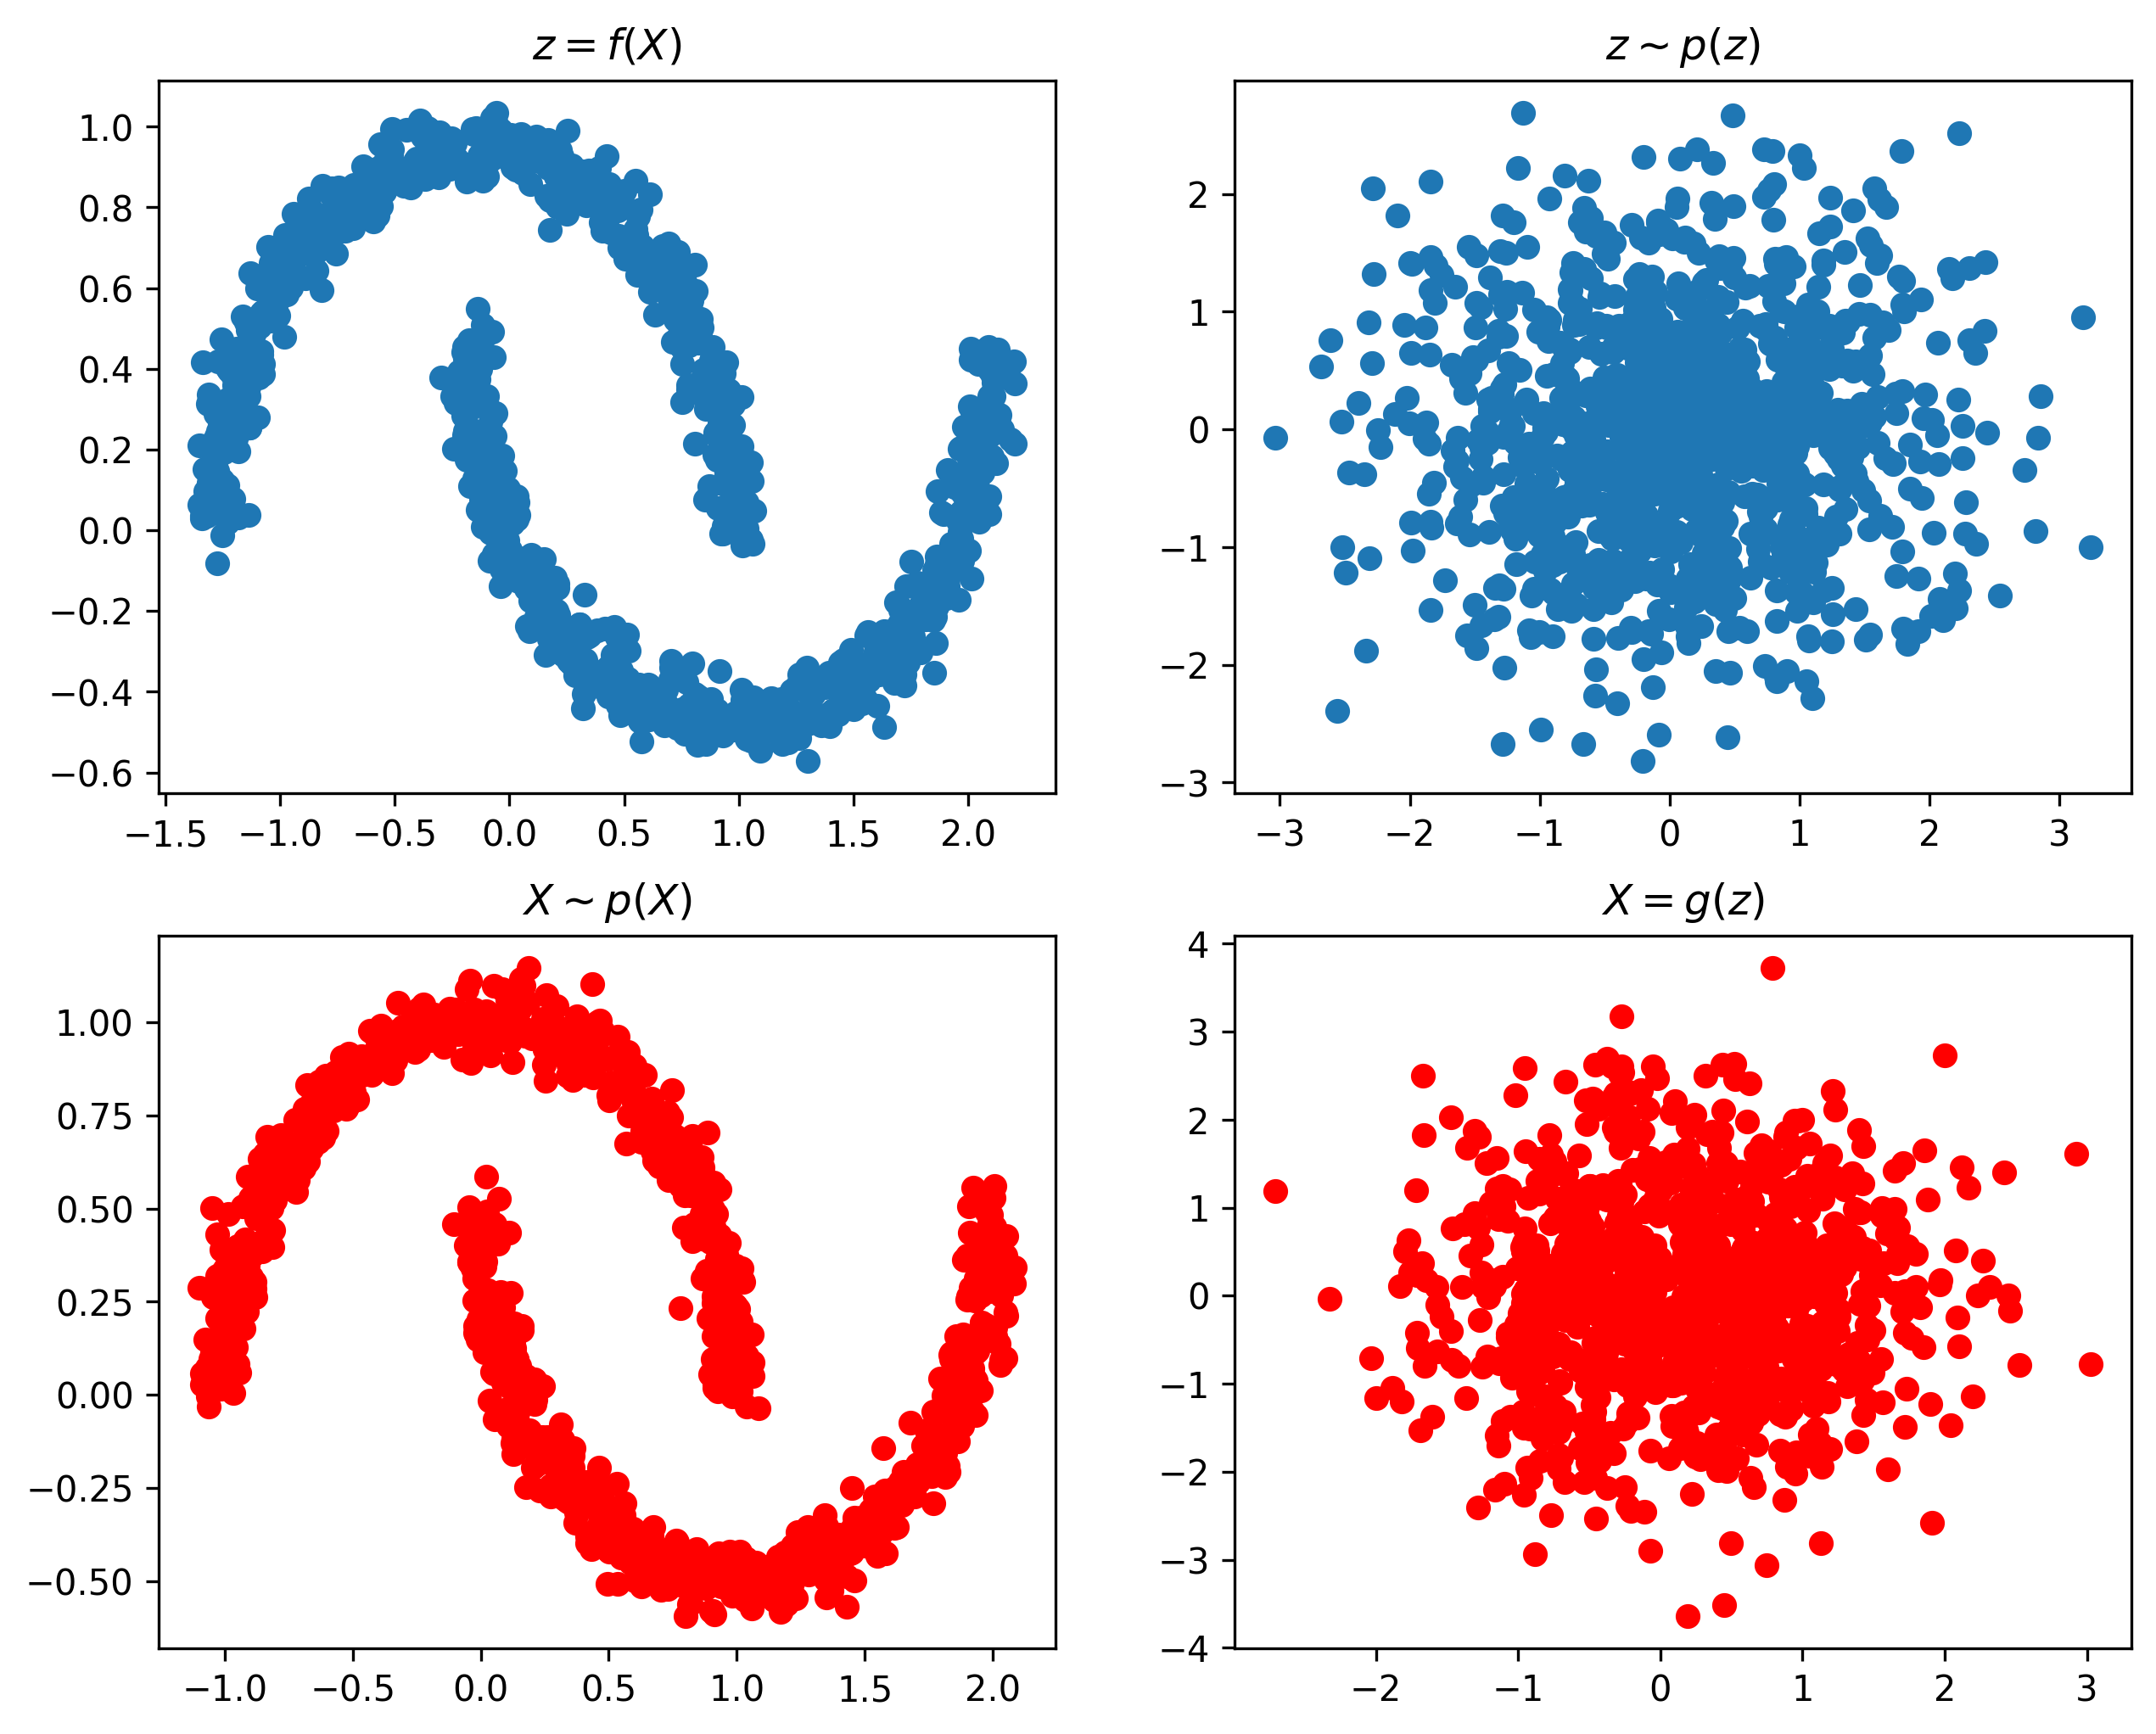

In [10]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

In [11]:
def create_and_train_model(x_dim, hidden_dim, n_layers, nonlinearity, initialization, number_of_coupling_layers):
    nets = lambda: create_model(n_layers, x_dim, hidden_dim, nonlinearity, initialization)
    nett = lambda: create_model(n_layers, x_dim, hidden_dim, nonlinearity, initialization)

    nets_test = nets()
    nett_test = nett()


    masks = torch.from_numpy(np.tile([[1, 0], [0, 1]], [int(number_of_coupling_layers / 2), 1]))

    prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

    flow = RealNVP(nets, nett, masks, prior)

    trainable_parameters = list(flow.s.parameters()) + list(flow.t.parameters())
    optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)

    for t in range(5001):
        noisy_moons = datasets.make_moons(n_samples=100, noise=.05)
        loss = -torch.mean(flow.log_prob(torch.from_numpy(noisy_moons[0]).float()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 500 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)
    return flow


In [12]:
def plot_results(flow):
    noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
    z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
    plt.subplot(221)
    plt.scatter(z[:, 0], z[:, 1])
    plt.title(r'$z = f(X)$')

    z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
    plt.subplot(222)
    plt.scatter(z[:, 0], z[:, 1])
    plt.title(r'$z \sim p(z)$')

    plt.subplot(223)
    x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
    plt.scatter(x[:, 0], x[:, 1], c='r')
    plt.title(r'$X \sim p(X)$')

    plt.subplot(224)
    x = flow.sample(1000).detach().numpy()
    plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
    plt.title(r'$X = g(z)$')

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=10)

iter 0: loss = 2.400
iter 500: loss = 0.636
iter 1000: loss = 0.340
iter 1500: loss = 0.409
iter 2000: loss = 0.486
iter 2500: loss = 0.475
iter 3000: loss = 0.434
iter 3500: loss = 0.448
iter 4000: loss = 0.433
iter 4500: loss = 0.297
iter 5000: loss = 0.313
CPU times: user 5min 20s, sys: 438 ms, total: 5min 20s
Wall time: 5min 21s


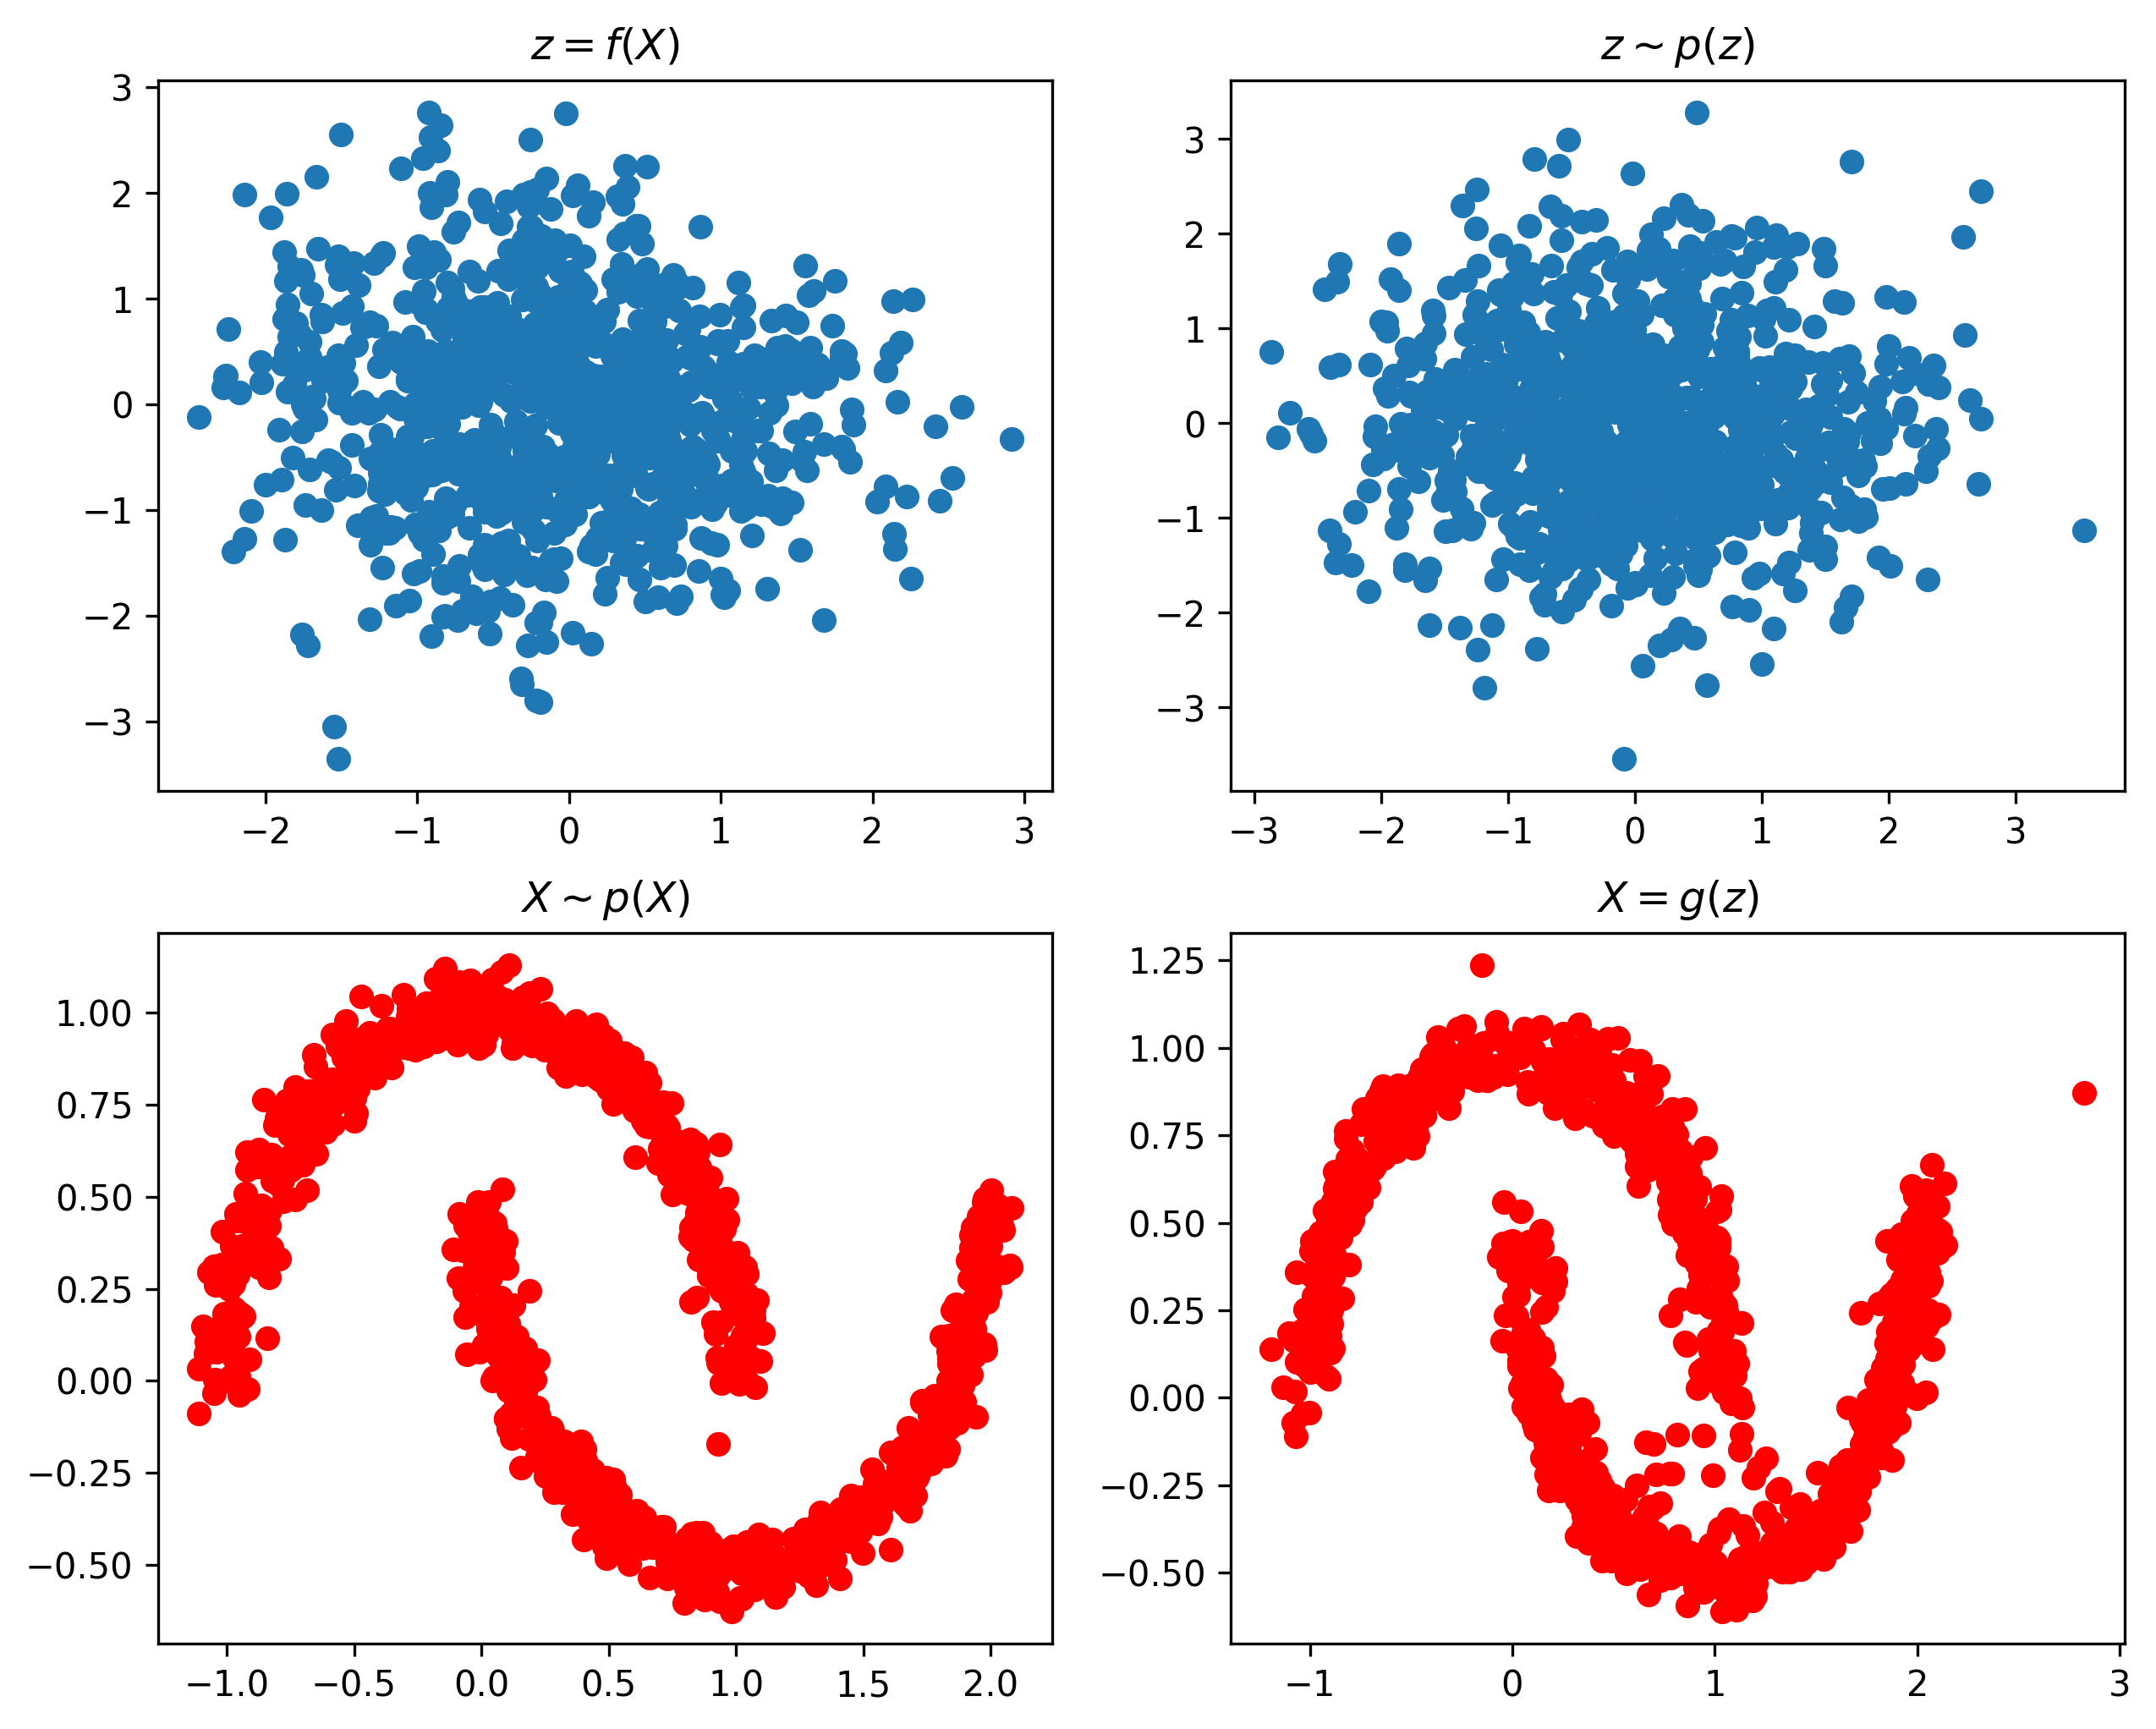

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=20)

iter 0: loss = 2.620
iter 500: loss = 0.560
iter 1000: loss = 0.457
iter 1500: loss = 0.493
iter 2000: loss = 0.430
iter 2500: loss = 0.336
iter 3000: loss = 0.376
iter 3500: loss = 0.297
iter 4000: loss = 0.515
iter 4500: loss = 0.268
iter 5000: loss = 0.316
CPU times: user 10min 47s, sys: 850 ms, total: 10min 48s
Wall time: 10min 50s


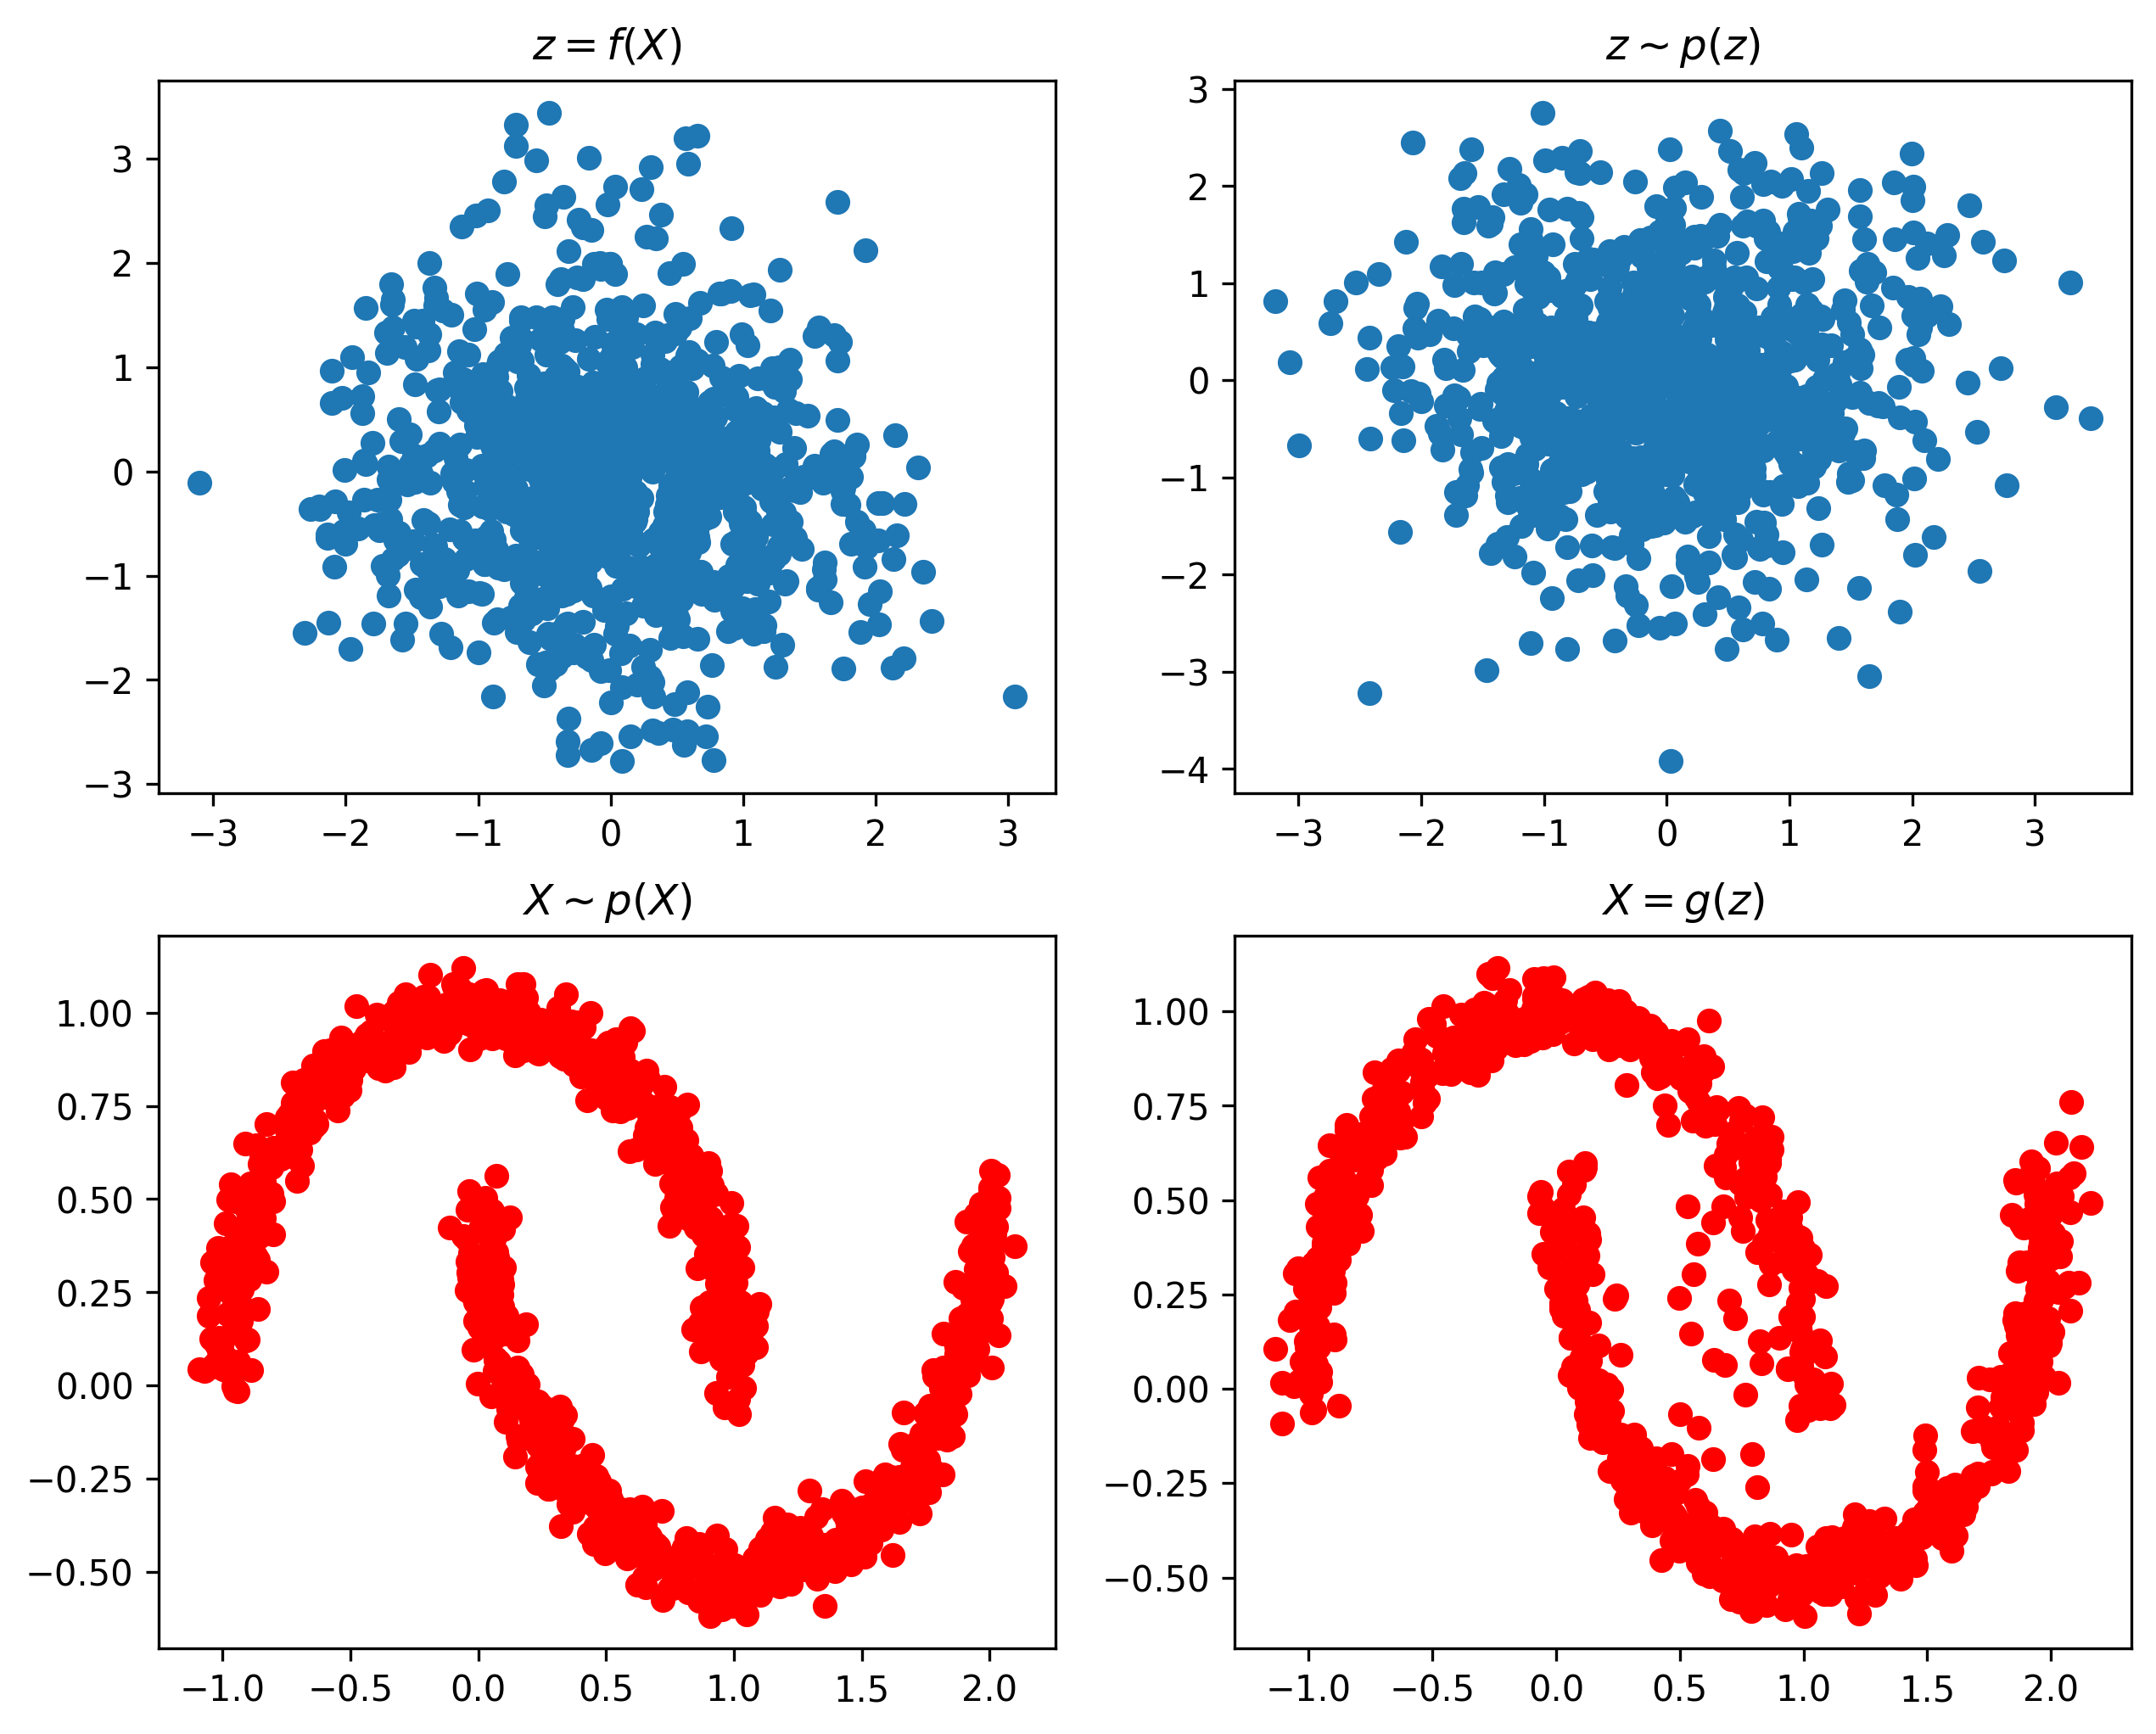

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=30)

iter 0: loss = 2.789
iter 500: loss = 0.508
iter 1000: loss = 0.492
iter 1500: loss = 0.412
iter 2000: loss = 0.409
iter 2500: loss = 0.504
iter 3000: loss = 0.291
iter 3500: loss = 0.431
iter 4000: loss = 0.366
iter 4500: loss = 0.312
iter 5000: loss = 0.261
CPU times: user 16min 44s, sys: 1.35 s, total: 16min 45s
Wall time: 16min 49s


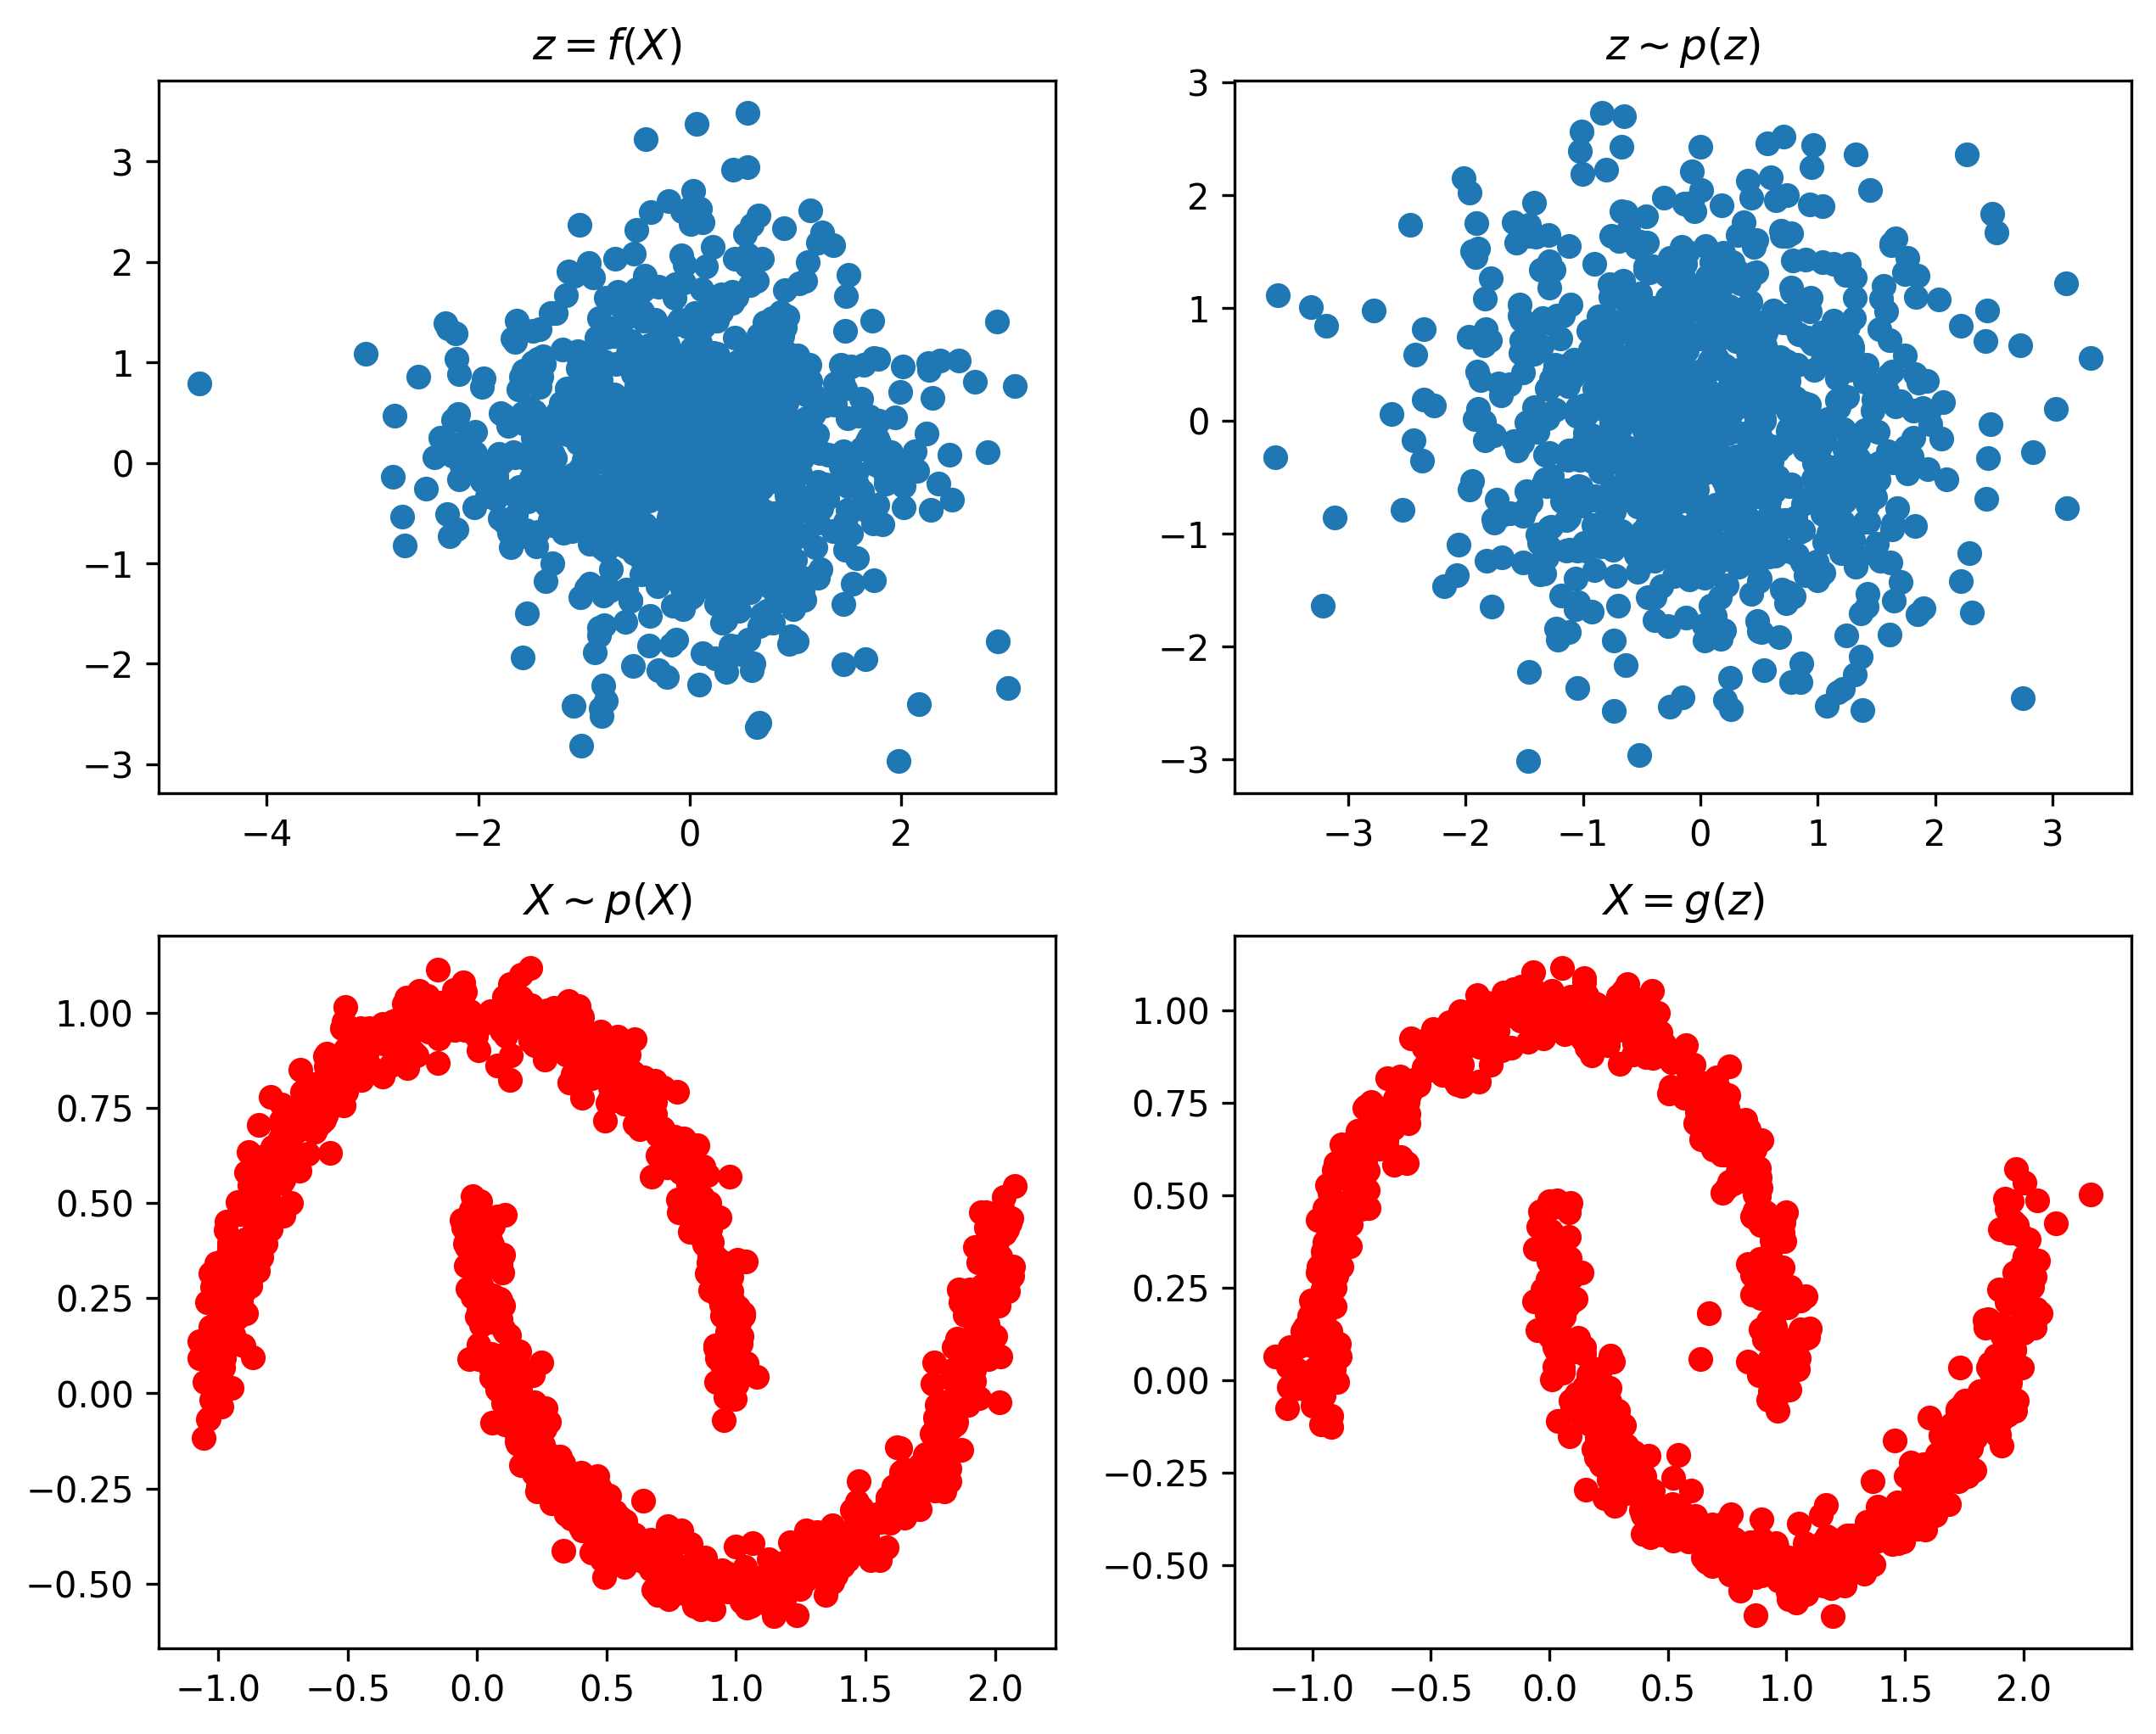

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.995
iter 500: loss = 0.530
iter 1000: loss = 0.483
iter 1500: loss = 0.252
iter 2000: loss = 0.439
iter 2500: loss = 0.343
iter 3000: loss = 0.360
iter 3500: loss = 0.515
iter 4000: loss = 0.288
iter 4500: loss = 0.438
iter 5000: loss = 0.338
CPU times: user 27min 33s, sys: 2.19 s, total: 27min 36s
Wall time: 27min 43s


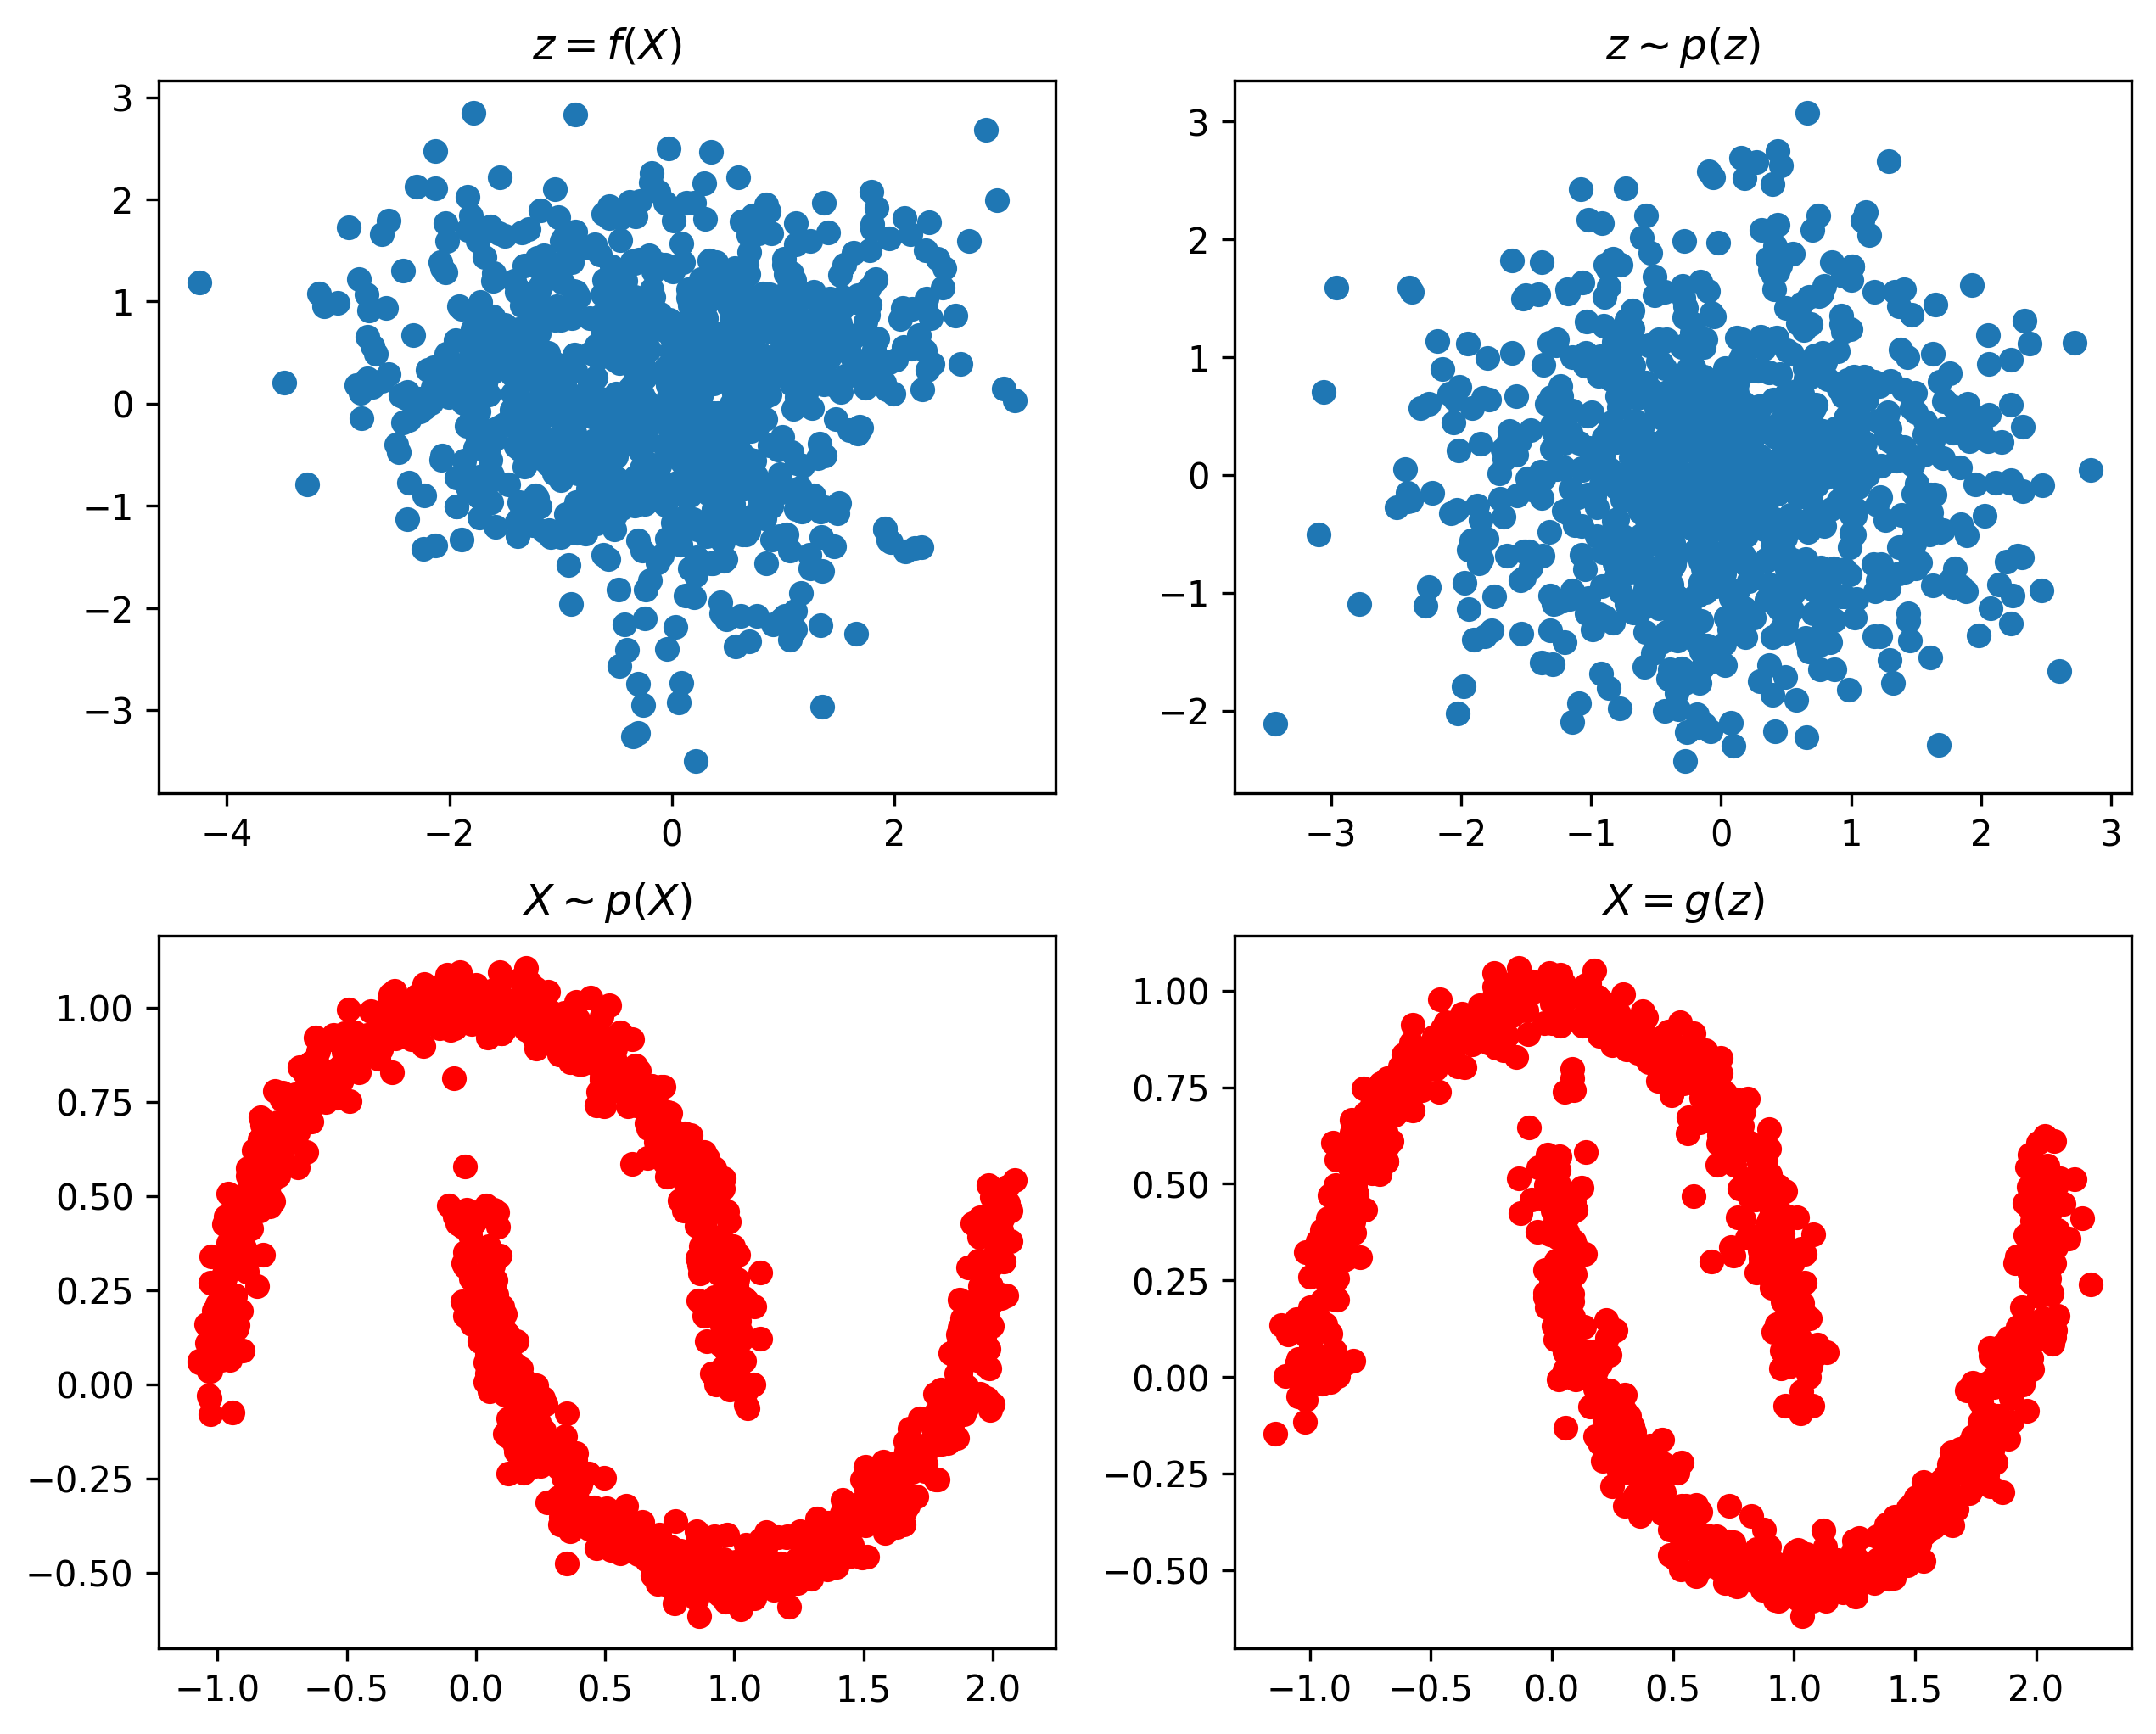

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=10, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.431
iter 500: loss = 0.724
iter 1000: loss = 0.626
iter 1500: loss = 0.604
iter 2000: loss = 0.524
iter 2500: loss = 0.393
iter 3000: loss = 0.640
iter 3500: loss = 0.557
iter 4000: loss = 0.431
iter 4500: loss = 0.871


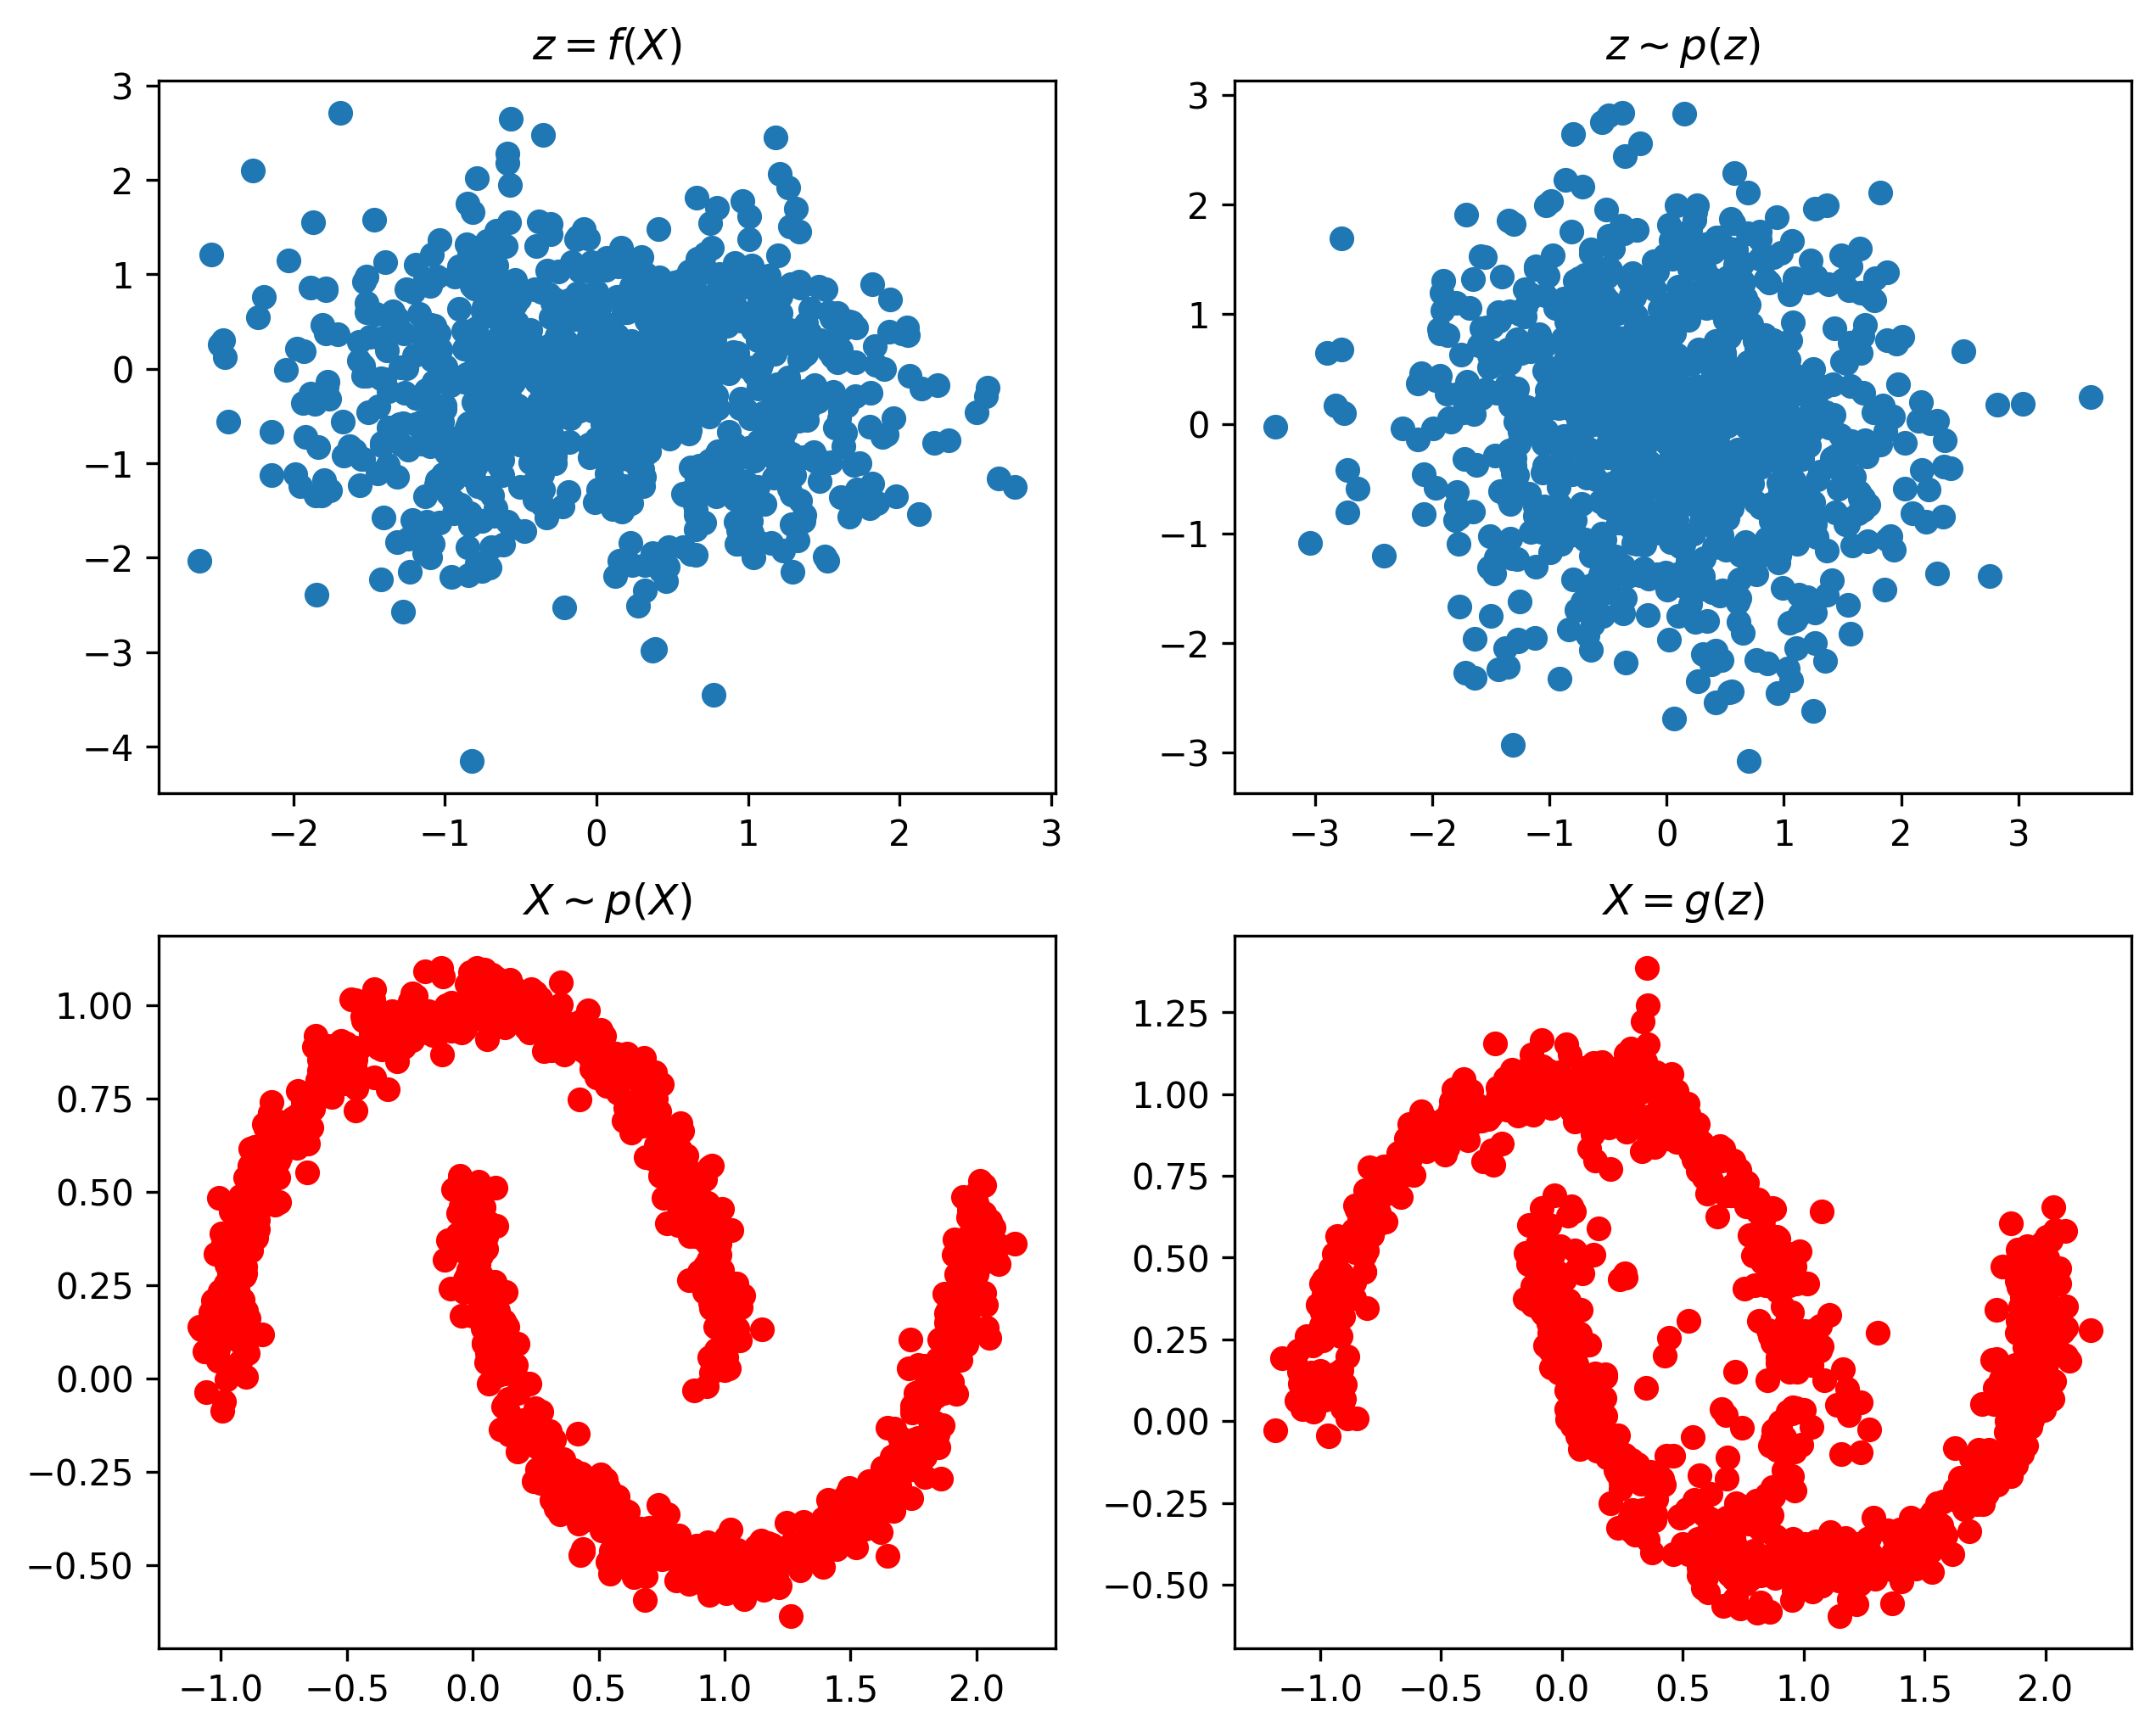

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.573
iter 500: loss = 0.589
iter 1000: loss = 0.412
iter 1500: loss = 0.443
iter 2000: loss = 0.410
iter 2500: loss = 0.469
iter 3000: loss = 0.399
iter 3500: loss = 0.413
iter 4000: loss = 0.416
iter 4500: loss = 0.585
iter 5000: loss = 0.325
CPU times: user 22min 13s, sys: 2.04 s, total: 22min 15s
Wall time: 22min 21s


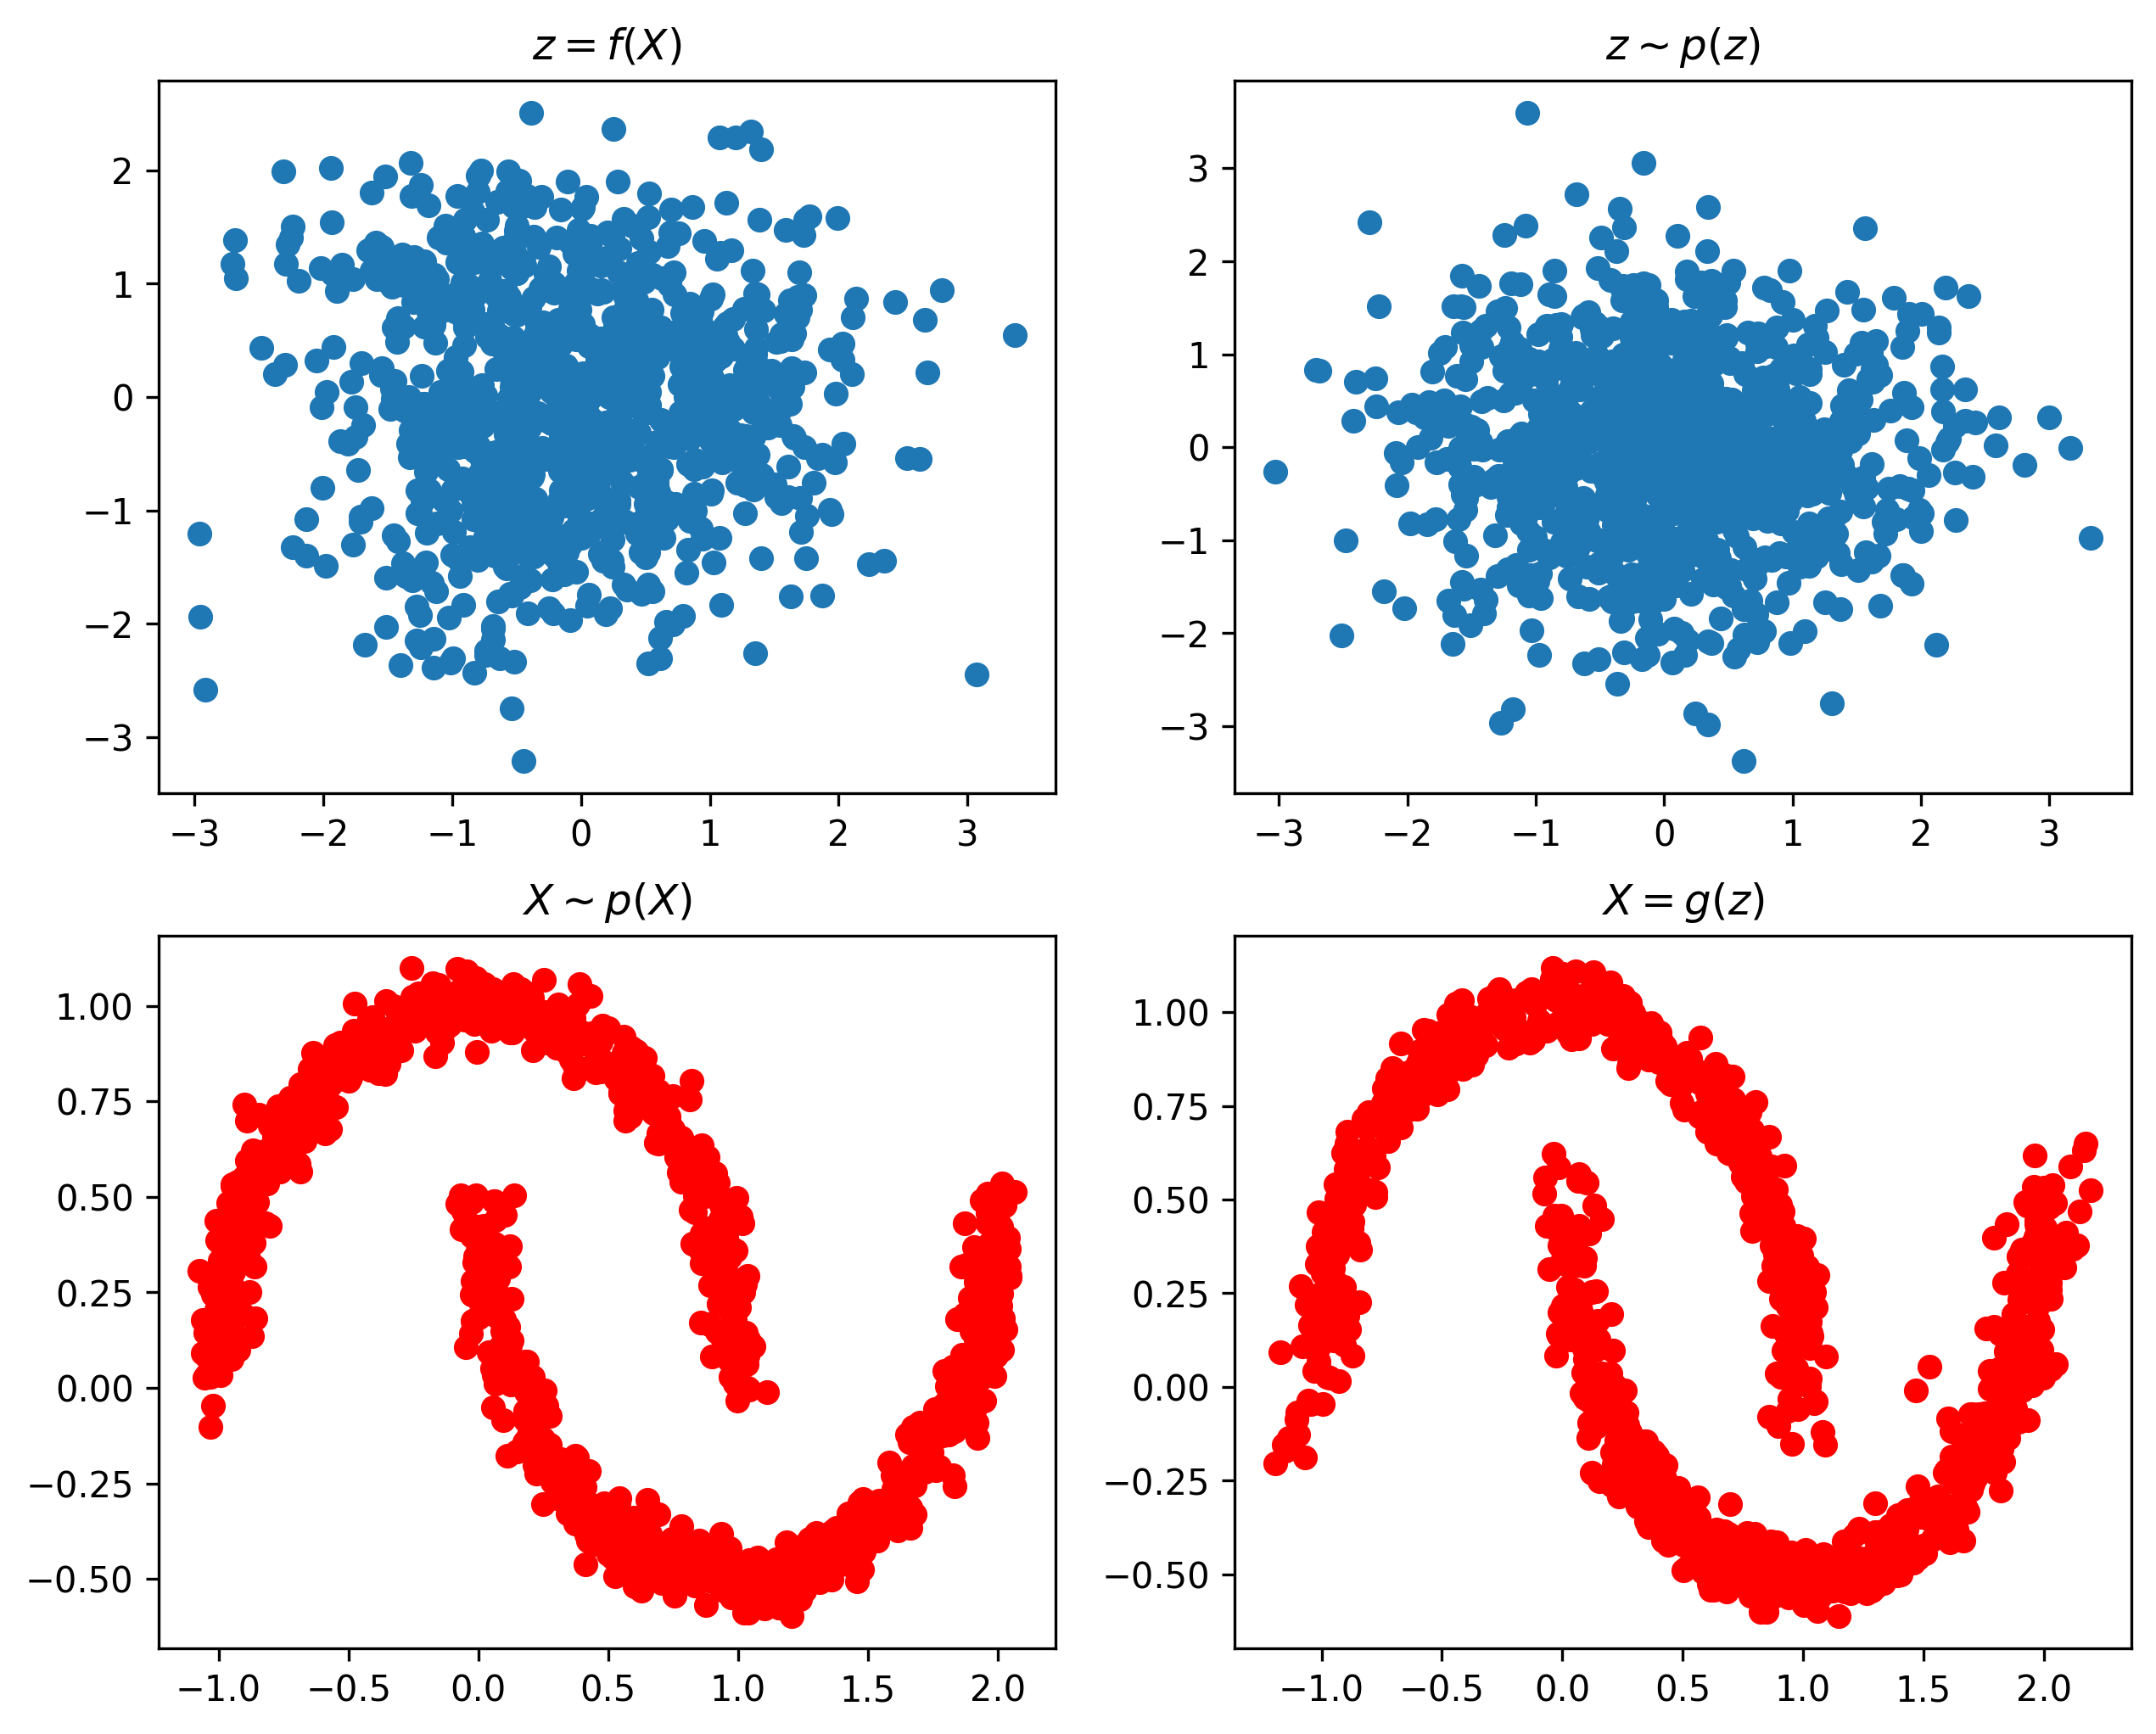

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.LeakyReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 3.212
iter 500: loss = 0.640
iter 1000: loss = 0.416
iter 1500: loss = 0.429
iter 2000: loss = 0.467
iter 2500: loss = 0.389
iter 3000: loss = 0.241
iter 3500: loss = 0.428
iter 4000: loss = 0.450
iter 4500: loss = 0.413
iter 5000: loss = 0.318
CPU times: user 22min 44s, sys: 2.2 s, total: 22min 46s
Wall time: 23min 2s


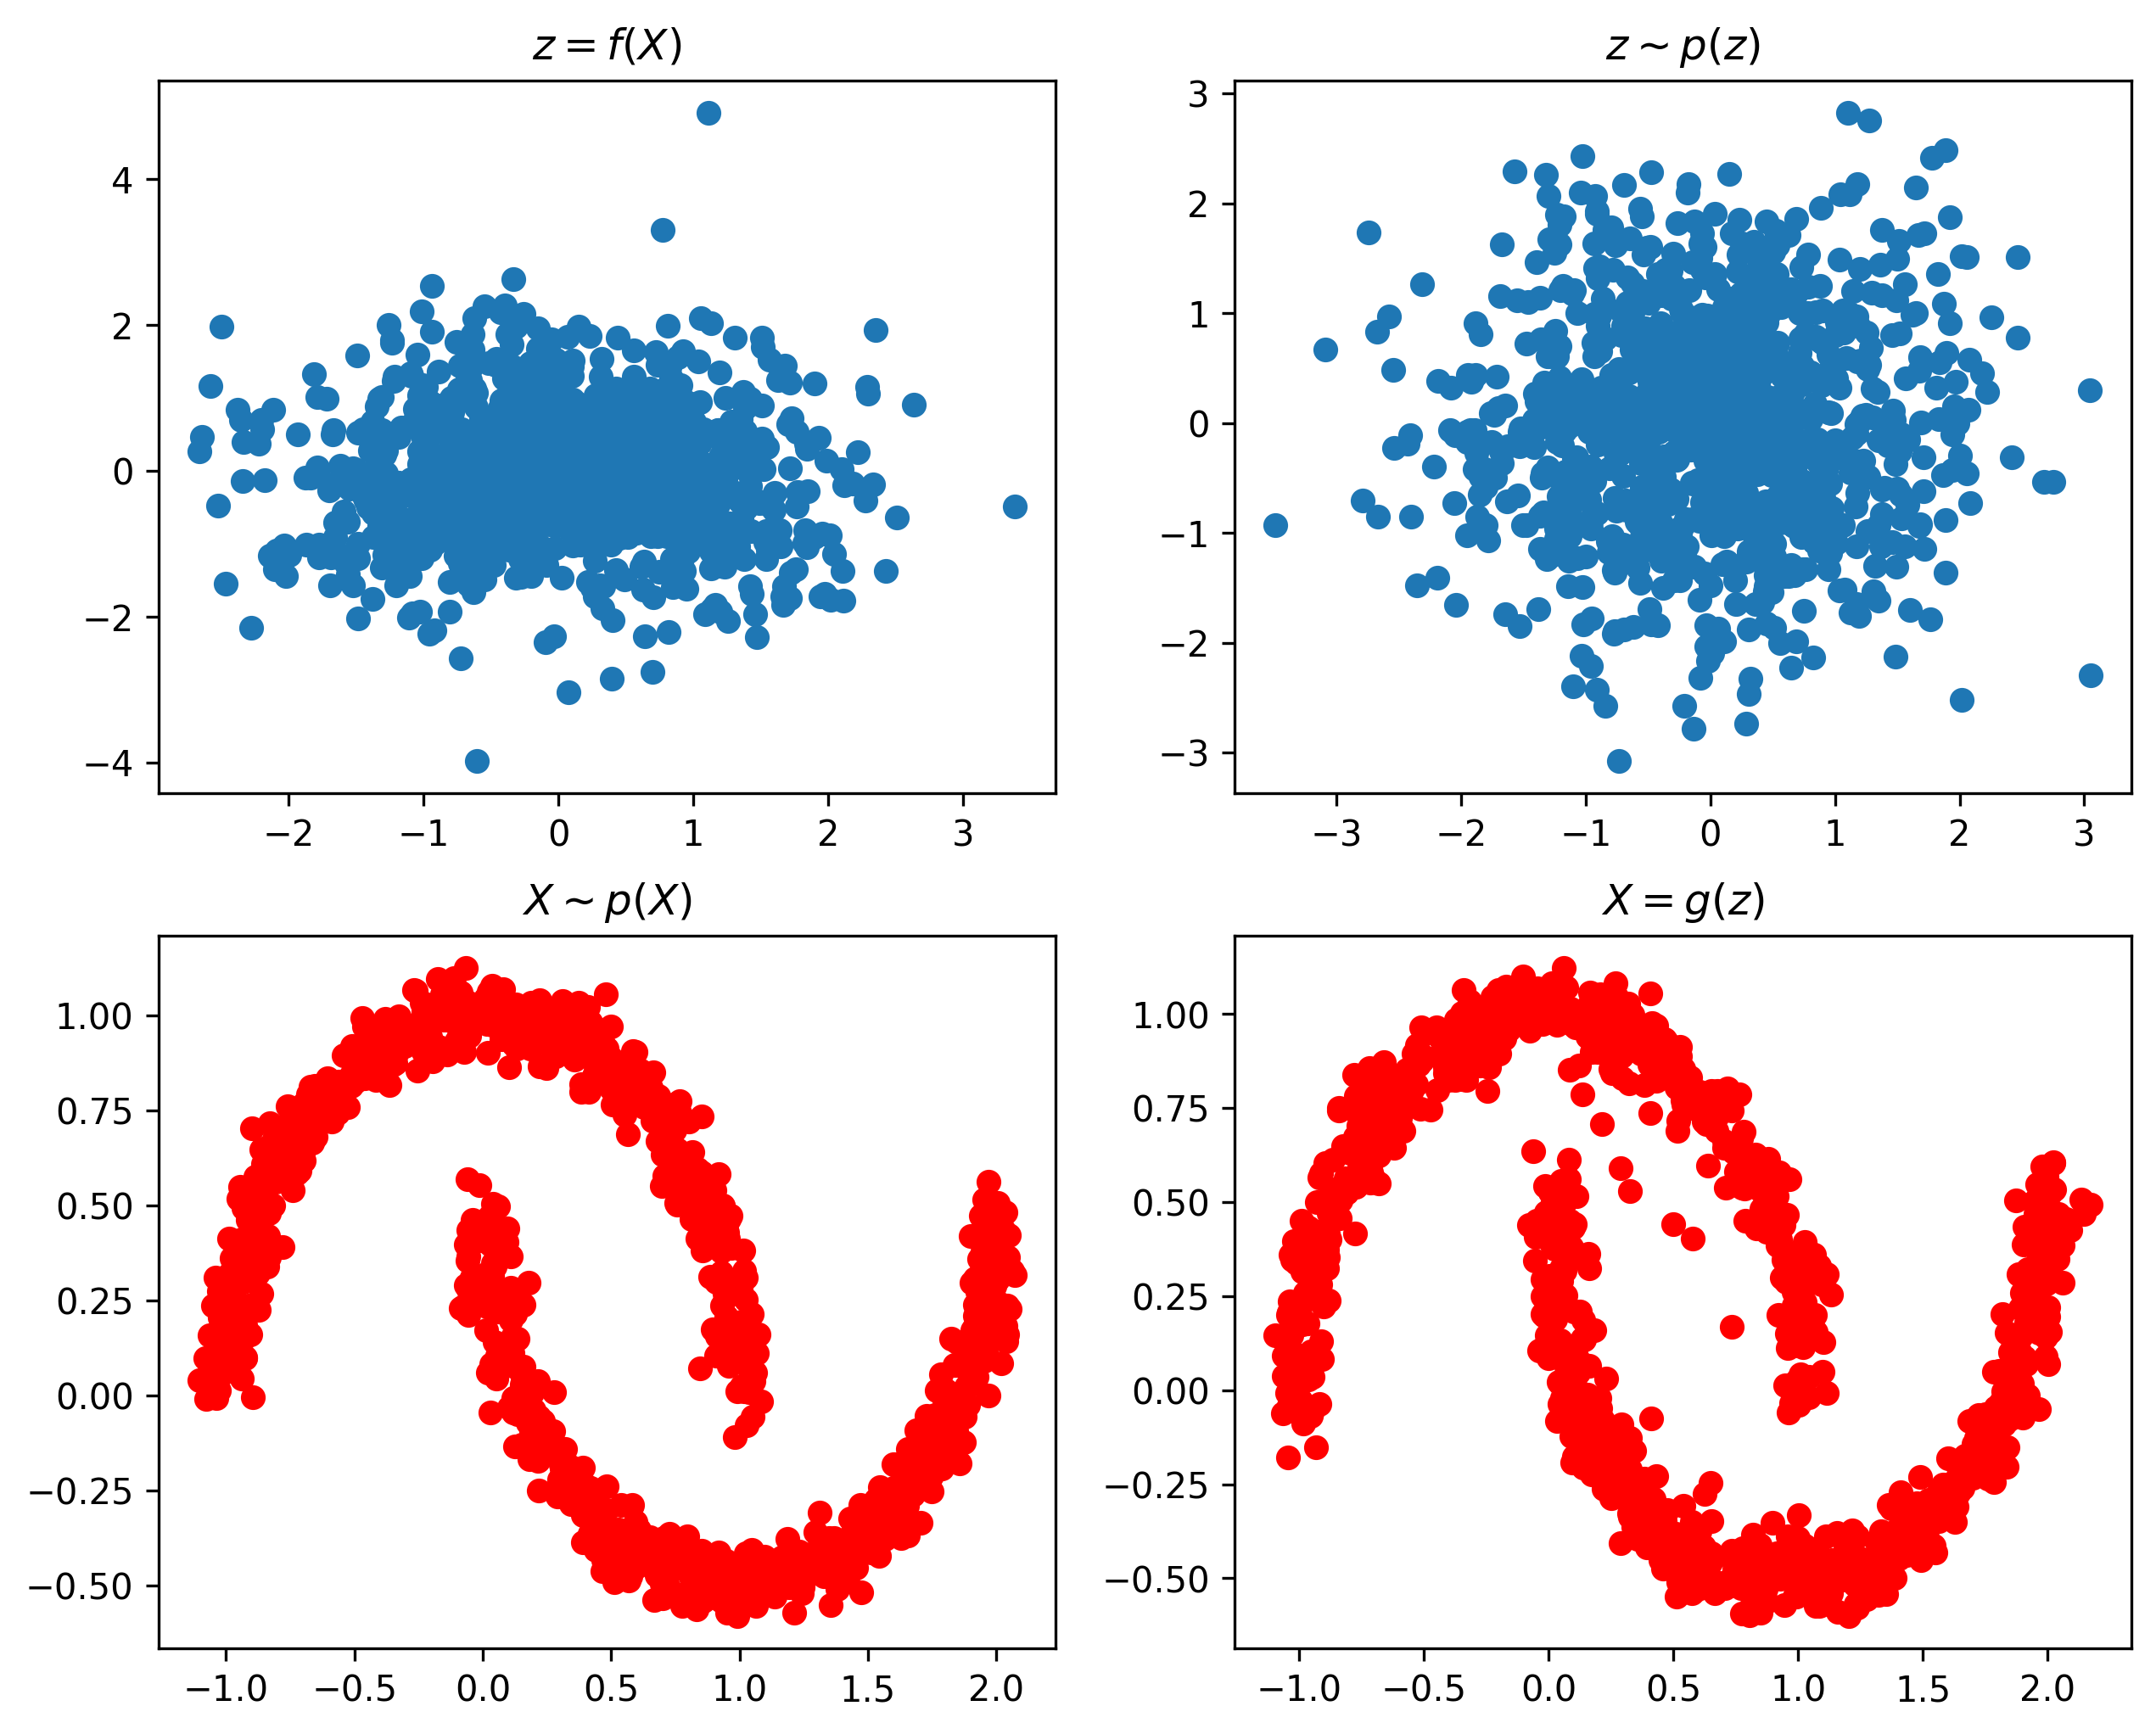

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.Sigmoid, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 59.556
iter 500: loss = 1.861
iter 1000: loss = 1.801
iter 1500: loss = 1.649
iter 2000: loss = 1.511
iter 2500: loss = 1.244
iter 3000: loss = 1.300
iter 3500: loss = 1.222
iter 4000: loss = 1.229
iter 4500: loss = 1.282
iter 5000: loss = 1.126
CPU times: user 23min 1s, sys: 2.02 s, total: 23min 3s
Wall time: 23min 11s


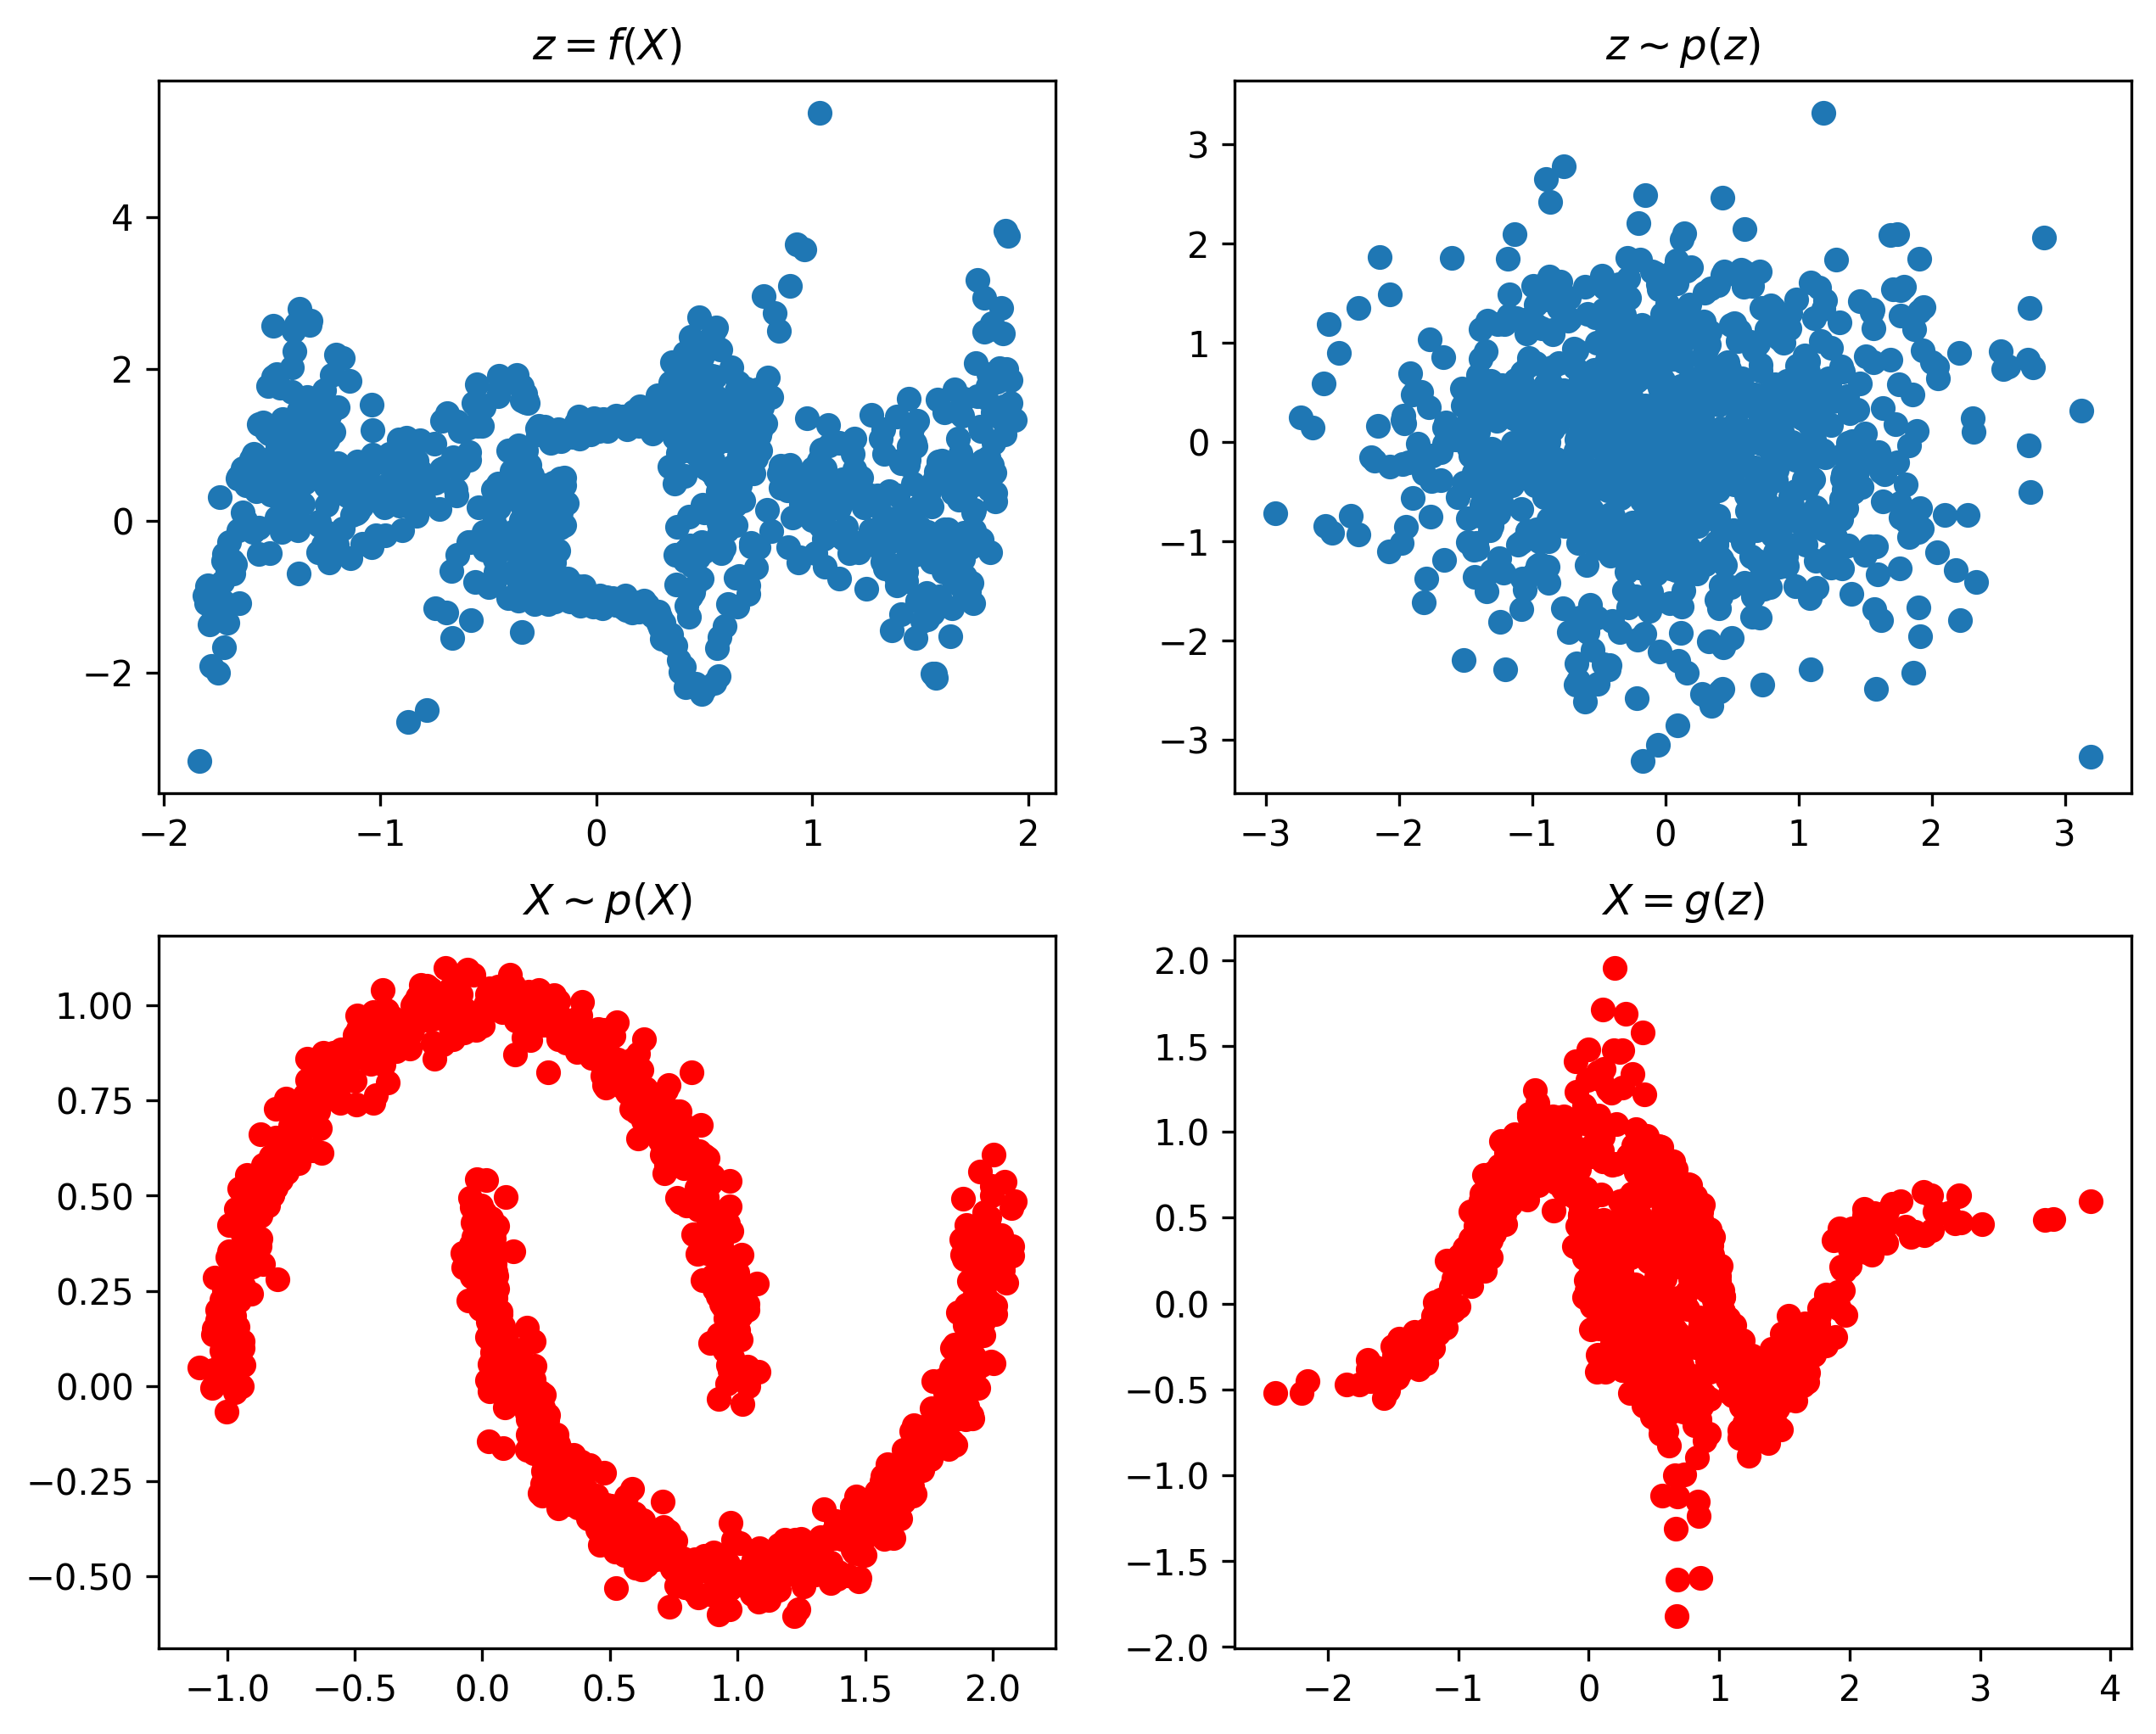

In [ ]:
plot_results(flow)

In [33]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.GELU, initialization=None, number_of_coupling_layers=50)


iter 0: loss = 3.795
iter 500: loss = 1.130
iter 1000: loss = 2.065
iter 1500: loss = 0.968
iter 2000: loss = 0.935
iter 2500: loss = 0.716
iter 3000: loss = 0.686
iter 3500: loss = 0.656
iter 4000: loss = 0.614
iter 4500: loss = 0.634
iter 5000: loss = 0.606
CPU times: user 3min 6s, sys: 153 ms, total: 3min 6s
Wall time: 3min 7s


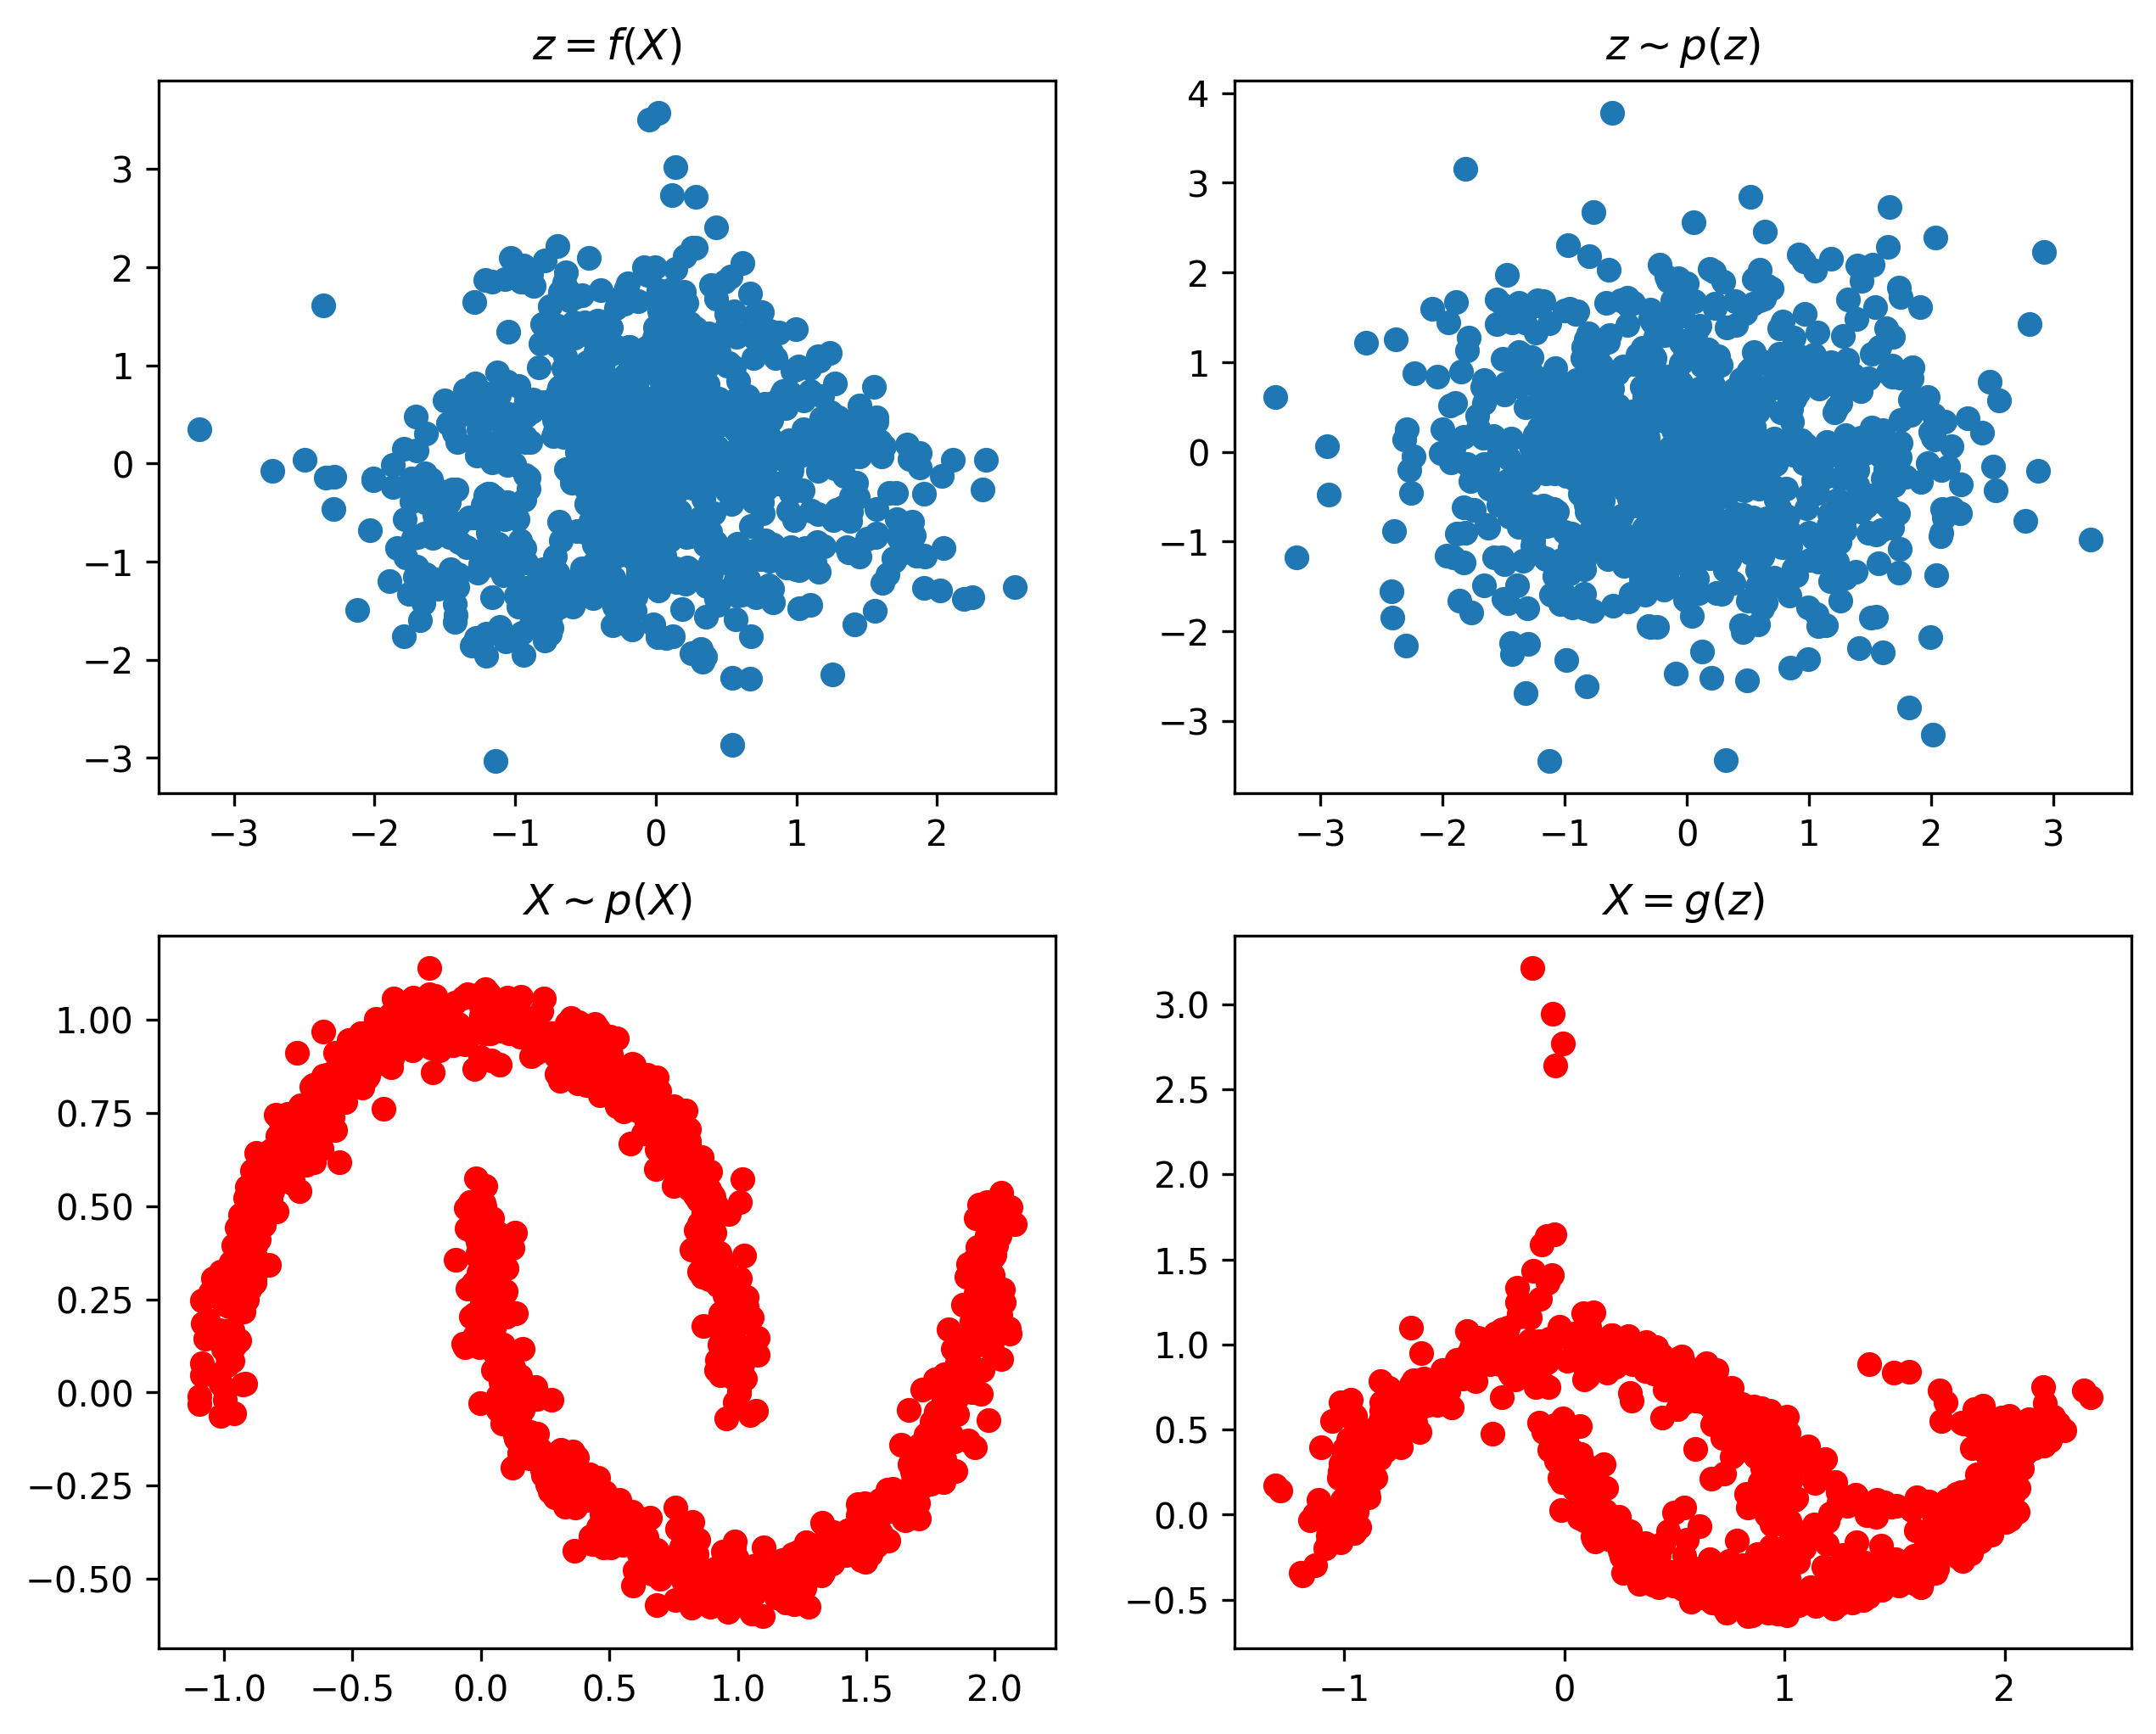

In [34]:
plot_results(flow)

In [13]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ELU, initialization=None, number_of_coupling_layers=50)


iter 0: loss = 2.339
iter 500: loss = 0.970
iter 1000: loss = 0.467
iter 1500: loss = 0.522
iter 2000: loss = 0.464
iter 2500: loss = 0.470
iter 3000: loss = 0.614
iter 3500: loss = 0.431
iter 4000: loss = 0.315
iter 4500: loss = 0.390
iter 5000: loss = 0.485
CPU times: user 31min 32s, sys: 3.12 s, total: 31min 35s
Wall time: 31min 46s


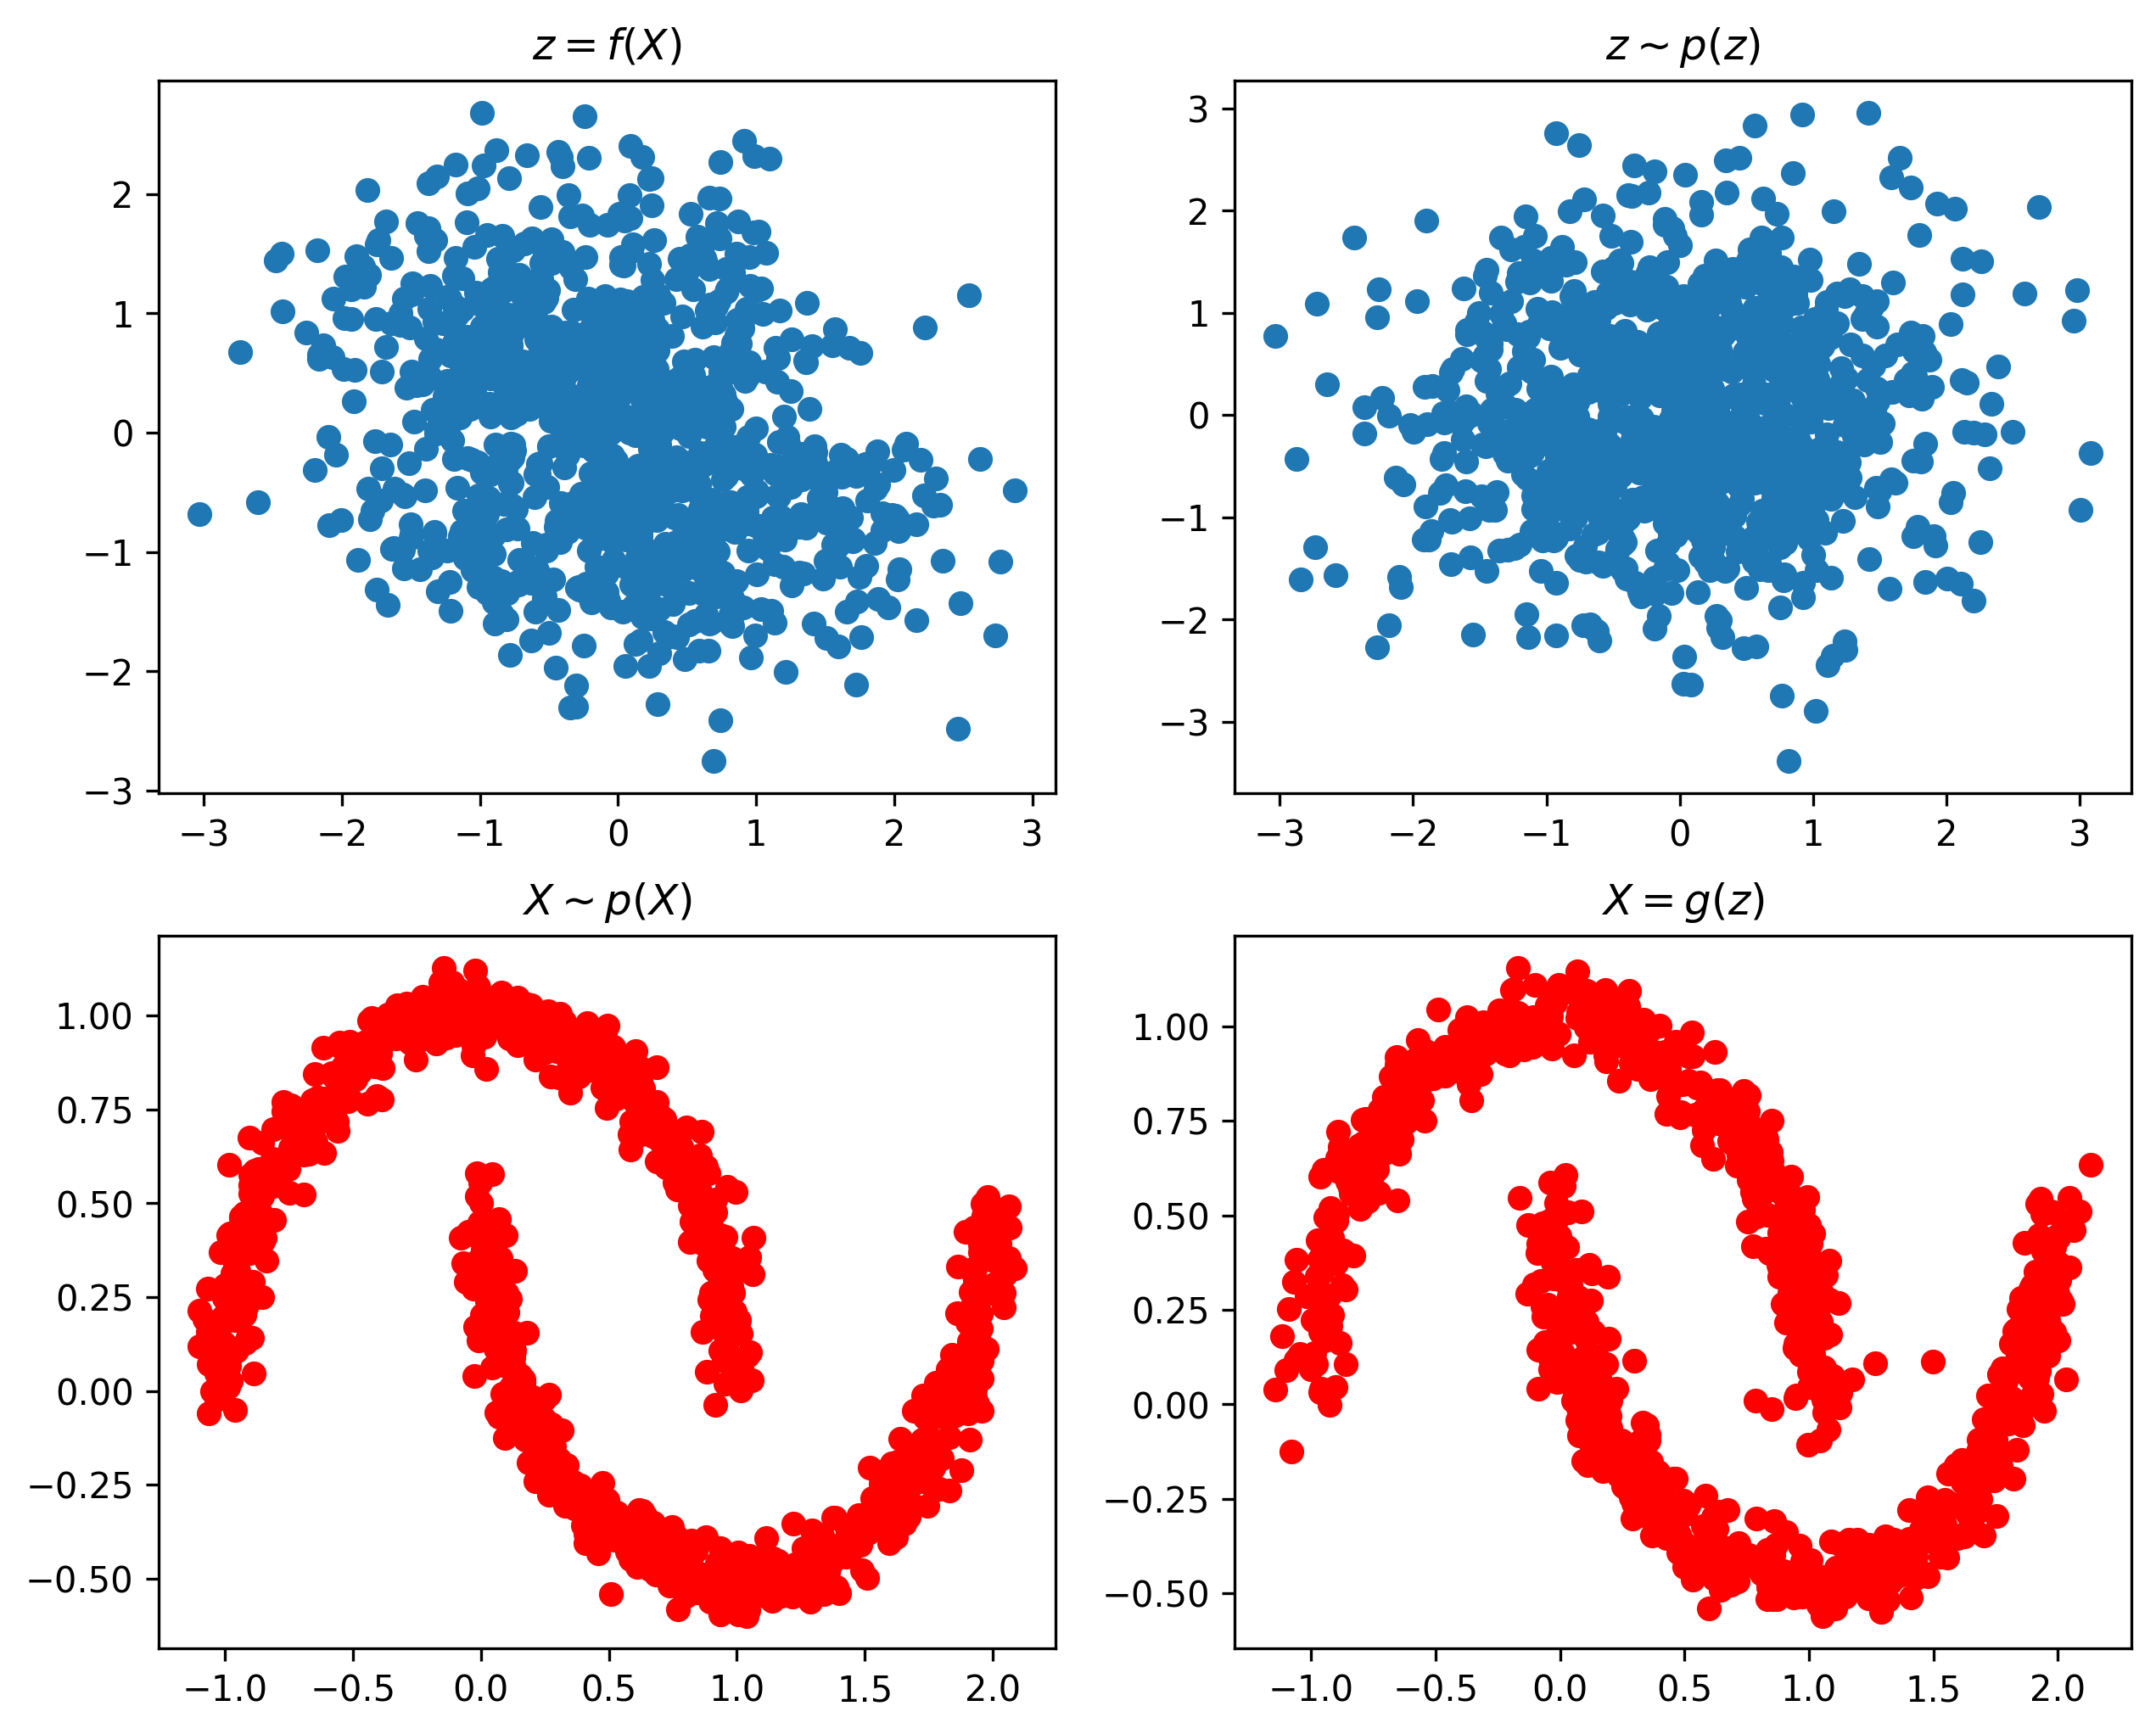

In [14]:
plot_results(flow)

In [15]:
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.PReLU, initialization=None, number_of_coupling_layers=50)


iter 0: loss = 2.940
iter 500: loss = 0.864
iter 1000: loss = 0.599
iter 1500: loss = 0.303
iter 2000: loss = 0.402
iter 2500: loss = 0.434
iter 3000: loss = 0.378
iter 3500: loss = 0.344
iter 4000: loss = 0.352
iter 4500: loss = 0.459
iter 5000: loss = 0.365


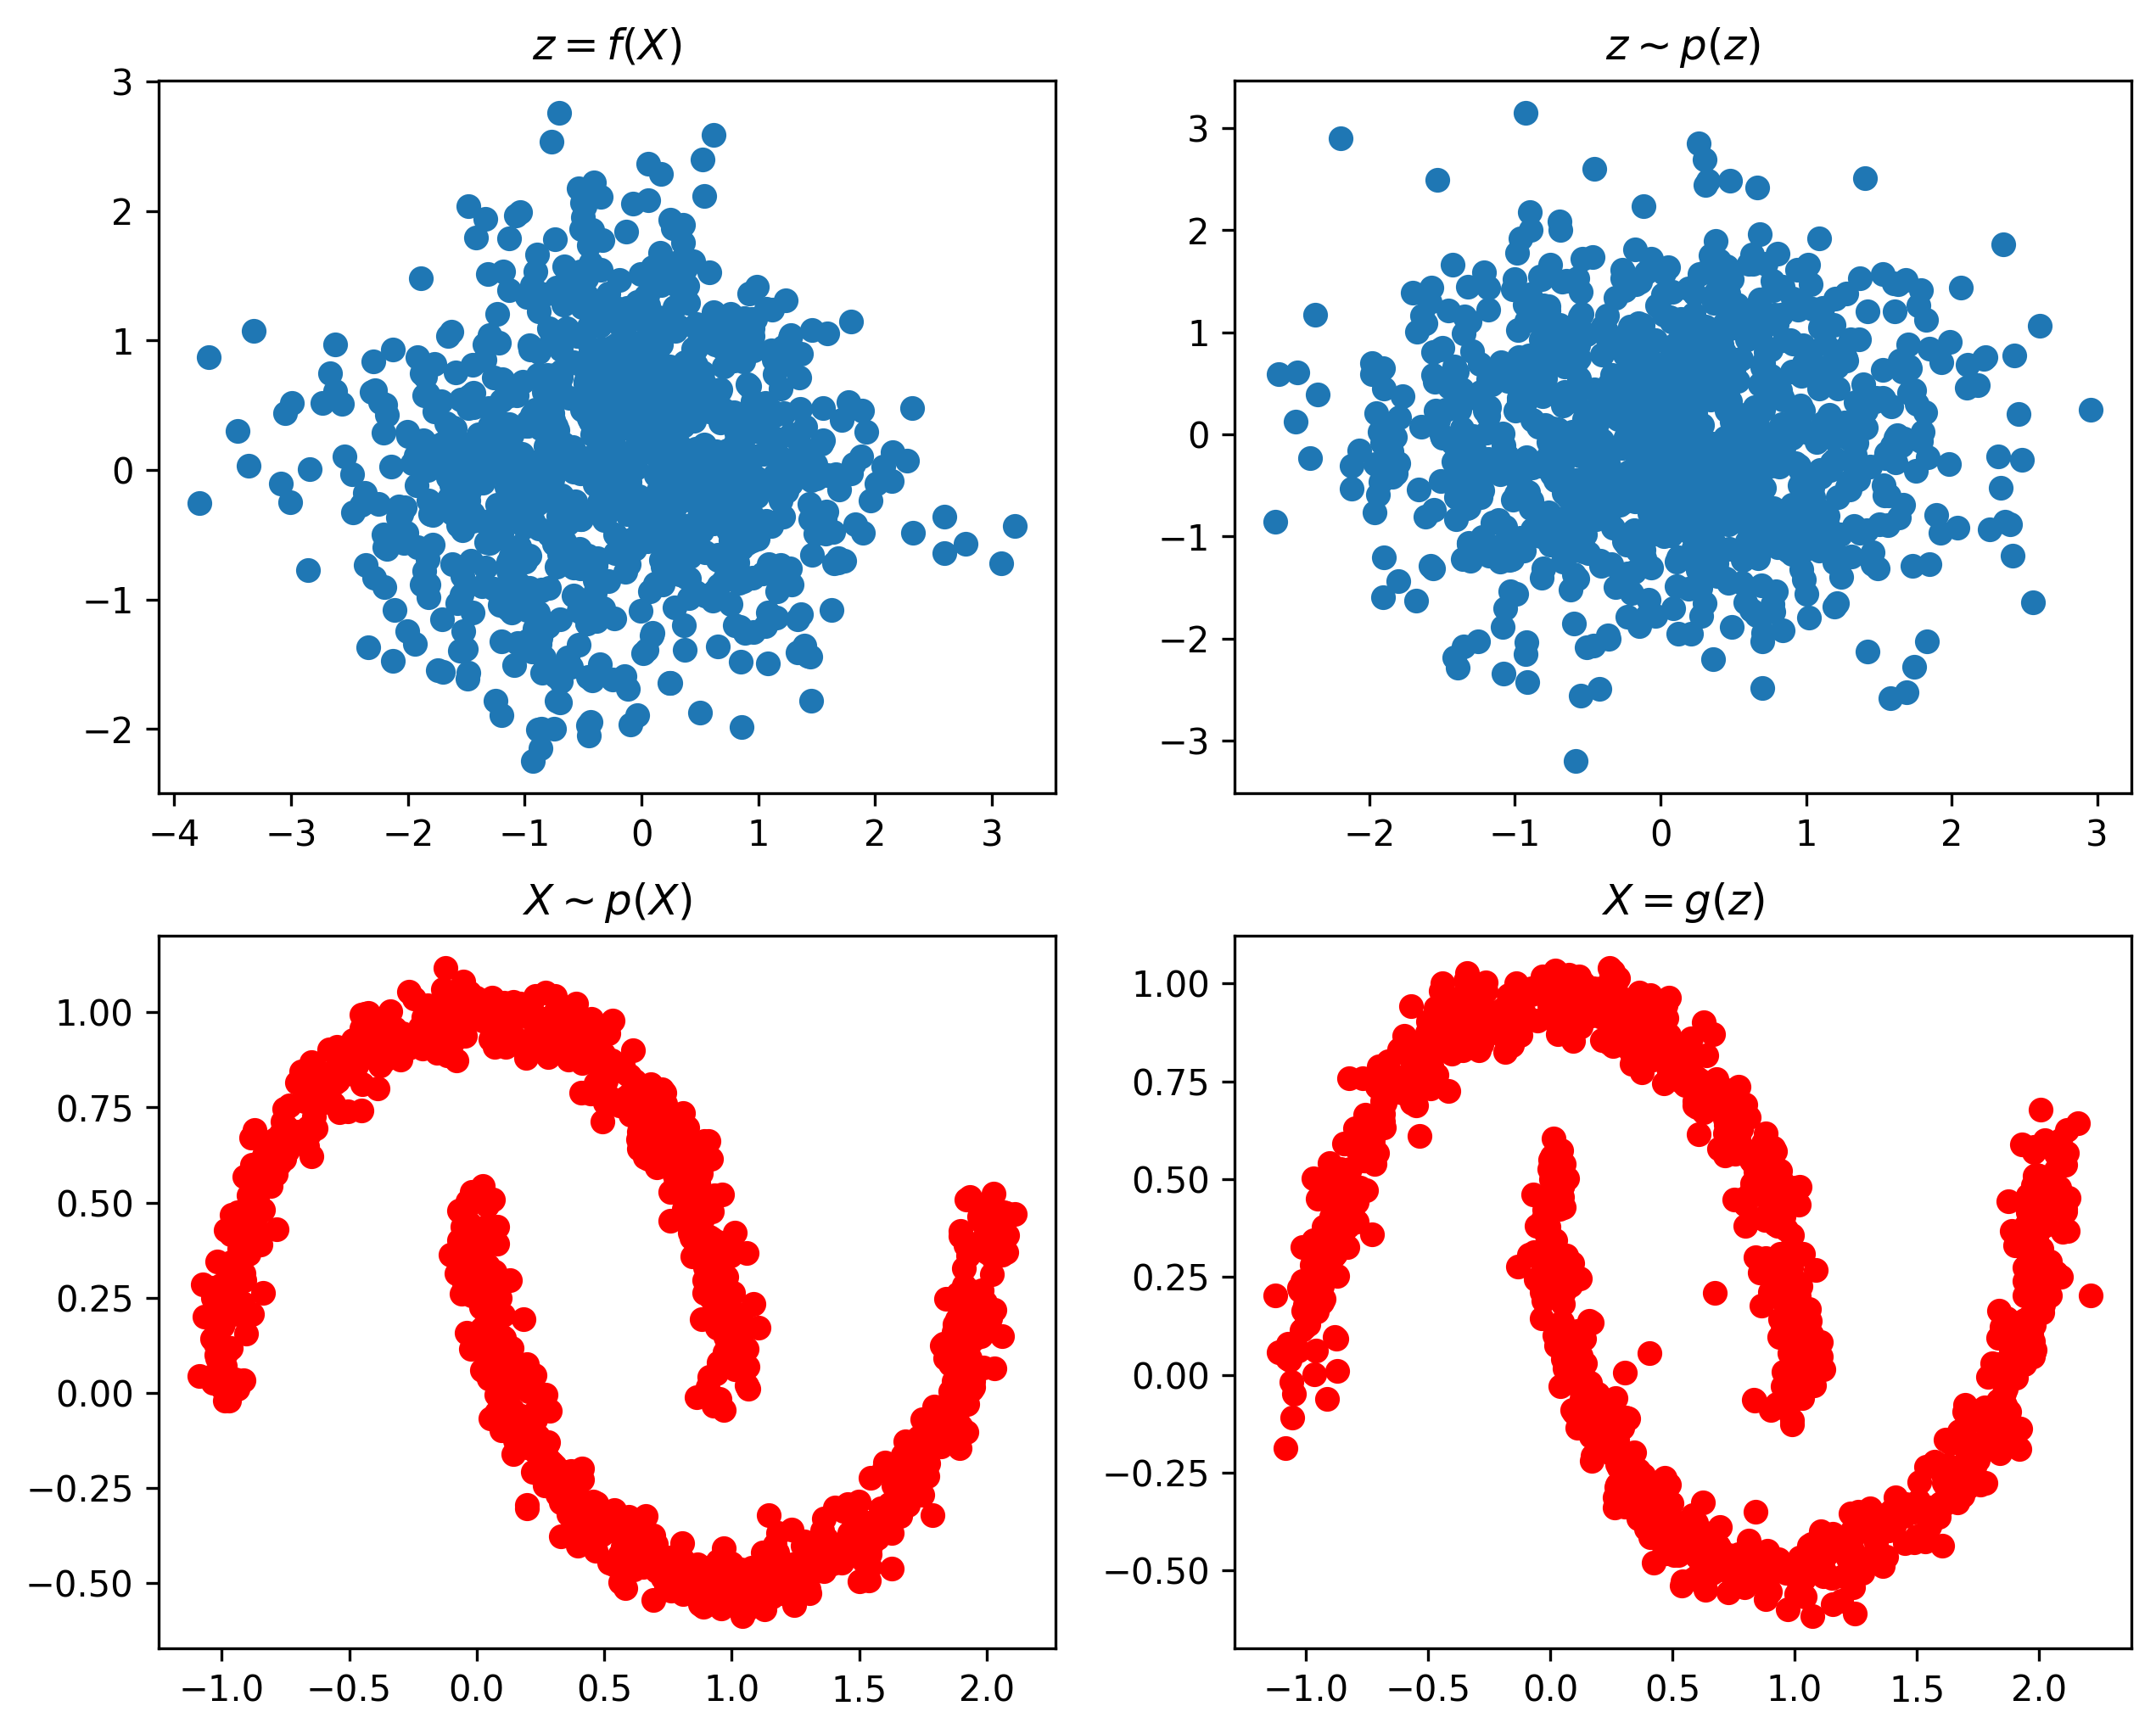

In [16]:
plot_results(flow)

## Provide answers for the folowing questions:

1. What architecture worked better in your experiments?


This model is a multi-layer fully connected neural network, consisting of an input layer, several hidden layers, and an output layer, with each linear layer followed by a nonlinear activation function. In these experiments, the model configuration with 5 linear layers, a hidden layer size of 128, and 50 coupling layers, using Tanh, ELu, and PreLu as nonlinear activation functions, performed the best.

2. Did you find what is important for stable training (initializations, nonlinearities, ...)?

In the initial experiments using the ReLU activation function, the results improved with an increase in the number of coupling layers. Visually, the results with 50 layers were the best, so this parameter was also chosen for subsequent experiments with other activation functions. The increase in the number of coupling layers made the model more adjustable and flexible. Regarding the number of linear layers, a configuration with 5 layers achieved the best results. Increasing the number of linear layers also significantly increased the training time of the network.

Among all considered activation functions, Tanh, ELu, and PreLu nonlinear activation functions achieved the highest quality of generated results, with almost no anomalies and irregularities at the edges. GELU and Sigmoid performed poorly, while ReLU and LeakyReLU also performed well.

Overall, in all experiments, the value of the loss function was decreasing, but in almost all cases, the decrease was not stable and smooth enough.

3. How convergence speed (in iterations) depends on the complexity of architecture?

As the size and complexity of the architecture increase, the learning time significantly increases. In this experiment, full convergence was not fully achieved. Since the default of 5000 training epochs was used in the experiment, it appears that more training epochs are needed to achieve full convergence in the loss values.








# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignments.   
#### 1. VAE:
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, then use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. More complex data:
Train NFs for a more complex dataset e.g. MNIST (downscale is possible), make samples look reasonable e.g., solid fraction of samples can be recognized as a valid digits. Worth to use Conv2d layers for s and t.
